In [1]:
import os
import pandas as pd

# Directory containing the TSV files
directory = '/nas/eclairnas01/users/pgerard/df_chunks_pro_russian'

# List to hold dataframes
dataframes = []

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith("_v2.tsv"):
        print(f'Grabbing {filename}')
        file_path = os.path.join(directory, filename)
        # Read the TSV file into a dataframe
        df = pd.read_csv(file_path, sep='\t')
        # Append the dataframe to the list
        dataframes.append(df)

# Concatenate all dataframes in the list
combined_df_ru = pd.concat(dataframes, ignore_index=True)

# import os
# import pandas as pd

# Directory containing the TSV files
directory = '/nas/eclairnas01/users/pgerard/df_chunks_pro_ukrainian'

# List to hold dataframes
dataframes = []

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith("uk_model_no_system_prompt.tsv"):
        print(f'Grabbing {filename}')
        file_path = os.path.join(directory, filename)
        # Read the TSV file into a dataframe
        df = pd.read_csv(file_path, sep='\t')
        # Append the dataframe to the list
        dataframes.append(df)

# Concatenate all dataframes in the list
combined_df_uk = pd.concat(dataframes, ignore_index=True)

combined_df = pd.concat([combined_df_uk, combined_df_ru], ignore_index=True)

Grabbing split_df_part_1_classified_with_logits_ru_no_system_prompt_v2.tsv
Grabbing split_df_part_2_classified_with_logits_ru_no_system_prompt_v2.tsv
Grabbing split_df_part_8_classified_with_logits_ru_no_system_prompt_v2.tsv
Grabbing split_df_part_3_classified_with_logits_ru_no_system_prompt_v2.tsv
Grabbing split_df_part_4_classified_with_logits_ru_no_system_prompt_v2.tsv
Grabbing split_df_part_5_classified_with_logits_ru_no_system_prompt_v2.tsv
Grabbing split_df_part_6_classified_with_logits_ru_no_system_prompt_v2.tsv
Grabbing split_df_part_7_classified_with_logits_ru_no_system_prompt_v2.tsv
Grabbing split_df_part_1_classified_with_logits_ru_no_system_prompt_classified_with_logits_ru_no_system_prompt_v2.tsv
Grabbing chunk_4_2022-02-20_to_2022-03-29_classified_with_logits_uk_model_no_system_prompt.tsv
Grabbing chunk_1_2016-03-31_to_2020-03-20_classified_with_logits_uk_model_no_system_prompt.tsv
Grabbing chunk_5_2022-03-29_to_2022-05-24_classified_with_logits_uk_model_no_system_prompt.t

/tmp/ipykernel_2323784/1834101574.py:38: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


Grabbing chunk_9_2023-01-21_to_2023-08-17_classified_with_logits_uk_model_no_system_prompt.tsv


/tmp/ipykernel_2323784/1834101574.py:38: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


Grabbing chunk_7_2022-08-11_to_2022-10-25_classified_with_logits_uk_model_no_system_prompt.tsv


/tmp/ipykernel_2323784/1834101574.py:38: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


In [2]:
combined_df = pd.concat([combined_df_uk, combined_df_ru], ignore_index=True)

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm

# Enable progress_apply for pandas
tqdm.pandas()

def convert_views(views_str):
    views_str = views_str.replace(',', '')
    if 'K' in views_str:
        return float(views_str.replace('K', '')) * 1000
    elif 'M' in views_str:
        return float(views_str.replace('M', '')) * 1000000
    else:
        return float(views_str)

def calculate_combined_proportion(x, classes, thresholds):
    if len(x) == 0:
        return np.nan
    otherism_count = sum(
        (x[category] >= thresholds[category]).astype(int)
        for category in classes
    ).sum()
    total_posts = len(x)
    return otherism_count / total_posts

def investigate_otherism_vs_views(data, classes, thresholds):
    # Convert views column
    # data['views'] = data['views'].apply(convert_views)
    
    # Calculate typical views for each channel
    typical_views = data.groupby('channel_name')['views'].median().reset_index()
    typical_views.columns = ['channel_name', 'typical_views']
    
    data = pd.merge(data, typical_views, on='channel_name', how='left')
    
    # Group by channel_name and time step (e.g., week or month)
    data['date'] = pd.to_datetime(data['date'])
    data['time_step'] = data['date'].dt.to_period('W')  # Group by week, change 'W' to 'M' for month
    
    # Calculate combined proportion for each group
    data['combined_proportion'] = data.groupby(['channel_name', 'time_step']).progress_apply(
        lambda x: calculate_combined_proportion(x, classes, thresholds)
    ).reset_index(drop=True)
    
    # Inspect combined_proportion distribution
    print("Combined Proportion Distribution:")
    print(data['combined_proportion'].describe())
    
    # Plot the combined_proportion distribution
    data['combined_proportion'].hist(bins=50)
    
    # Calculate otherism increase
    data['otherism_increase'] = data.groupby('channel_name')['combined_proportion'].diff().fillna(0) > 0
    
    # Inspect how many rows have detected increases
    print("Number of detected increases in otherism:", data['otherism_increase'].sum())
    
    if data['otherism_increase'].sum() == 0:
        raise ValueError("No increases in otherism detected with the current thresholds.")
    
    data['views_change'] = data['views'] - data['typical_views']
    
    filtered_data = data[data['otherism_increase']]
    
    X = filtered_data[['combined_proportion', 'typical_views']]
    y = filtered_data['views_change']
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X)
    results = model.fit()
    
    print(results.summary())
    return data, results

# Example usage:
classes = [
    'Threats to Culture or Identity', 
    'Threats to Survival or Physical Security', 
    'Vilification/Villainization',
    'Explicit Dehumanization'
]
thresholds = {
    'Threats to Culture or Identity': 0.9, 
    'Threats to Survival or Physical Security': 0.9, 
    'Vilification/Villainization': 0.9, 
    'Explicit Dehumanization': 0.9
}

data, regression_results = investigate_otherism_vs_views(combined_df_ru, classes, thresholds)

print(data.head())


KeyboardInterrupt: 

Data types:
 user                                         object
post_id                                       int64
url                                          object
title                                        object
image_url                                    object
description                                  object
views                                        object
date                                         object
channel_name                                 object
channel_label                                object
cleaned_description                          object
cleaned_sentences                            object
Threats to Culture or Identity              float64
Threats to Survival or Physical Security    float64
Vilification/Villainization                 float64
Explicit Dehumanization                     float64
None                                        float64
classifications                              object
explanation                                  object

/tmp/ipykernel_118709/1430782127.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
/tmp/ipykernel_118709/1430782127.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views'] = data['views'].apply(convert_views)



Data filtered by date range (2022-01-01 to 2023-12-31) - Number of records: 126505


/tmp/ipykernel_118709/1430782127.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_otherism'] = data.apply(
/tmp/ipykernel_118709/1430782127.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views_normalized'] = data.groupby('channel_name')['views'].transform(



Number of posts with otherism: 21946
Number of posts without otherism: 104559
Mean normalized views with otherism: 0.09401512781608384
Mean normalized views without otherism: -0.019732935424514174
U-Statistic: 1226288675.5
P-Value: 5.3031466208156684e-58
Mean Normalized Views with Otherism: 0.09401512781608384
Mean Normalized Views without Otherism: -0.019732935424514174
There is a statistically significant difference in normalized views between posts with and without otherism.


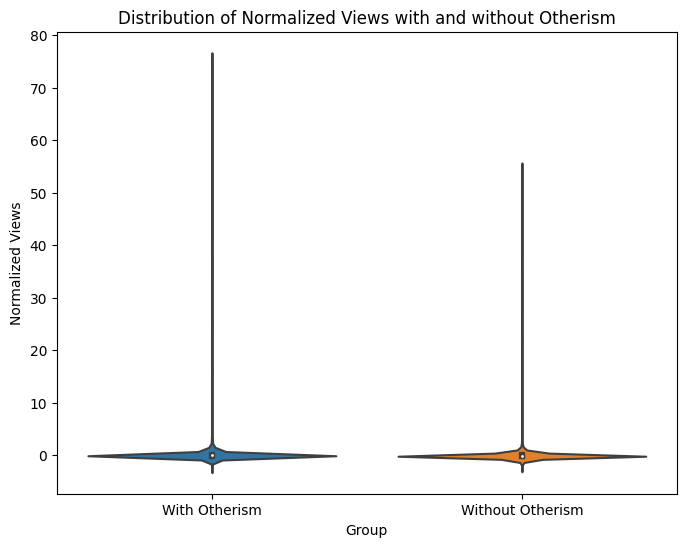

Data types:
 user                                         object
post_id                                       int64
url                                          object
title                                        object
image_url                                    object
description                                  object
views                                        object
date                                         object
channel_name                                 object
channel_label                                object
cleaned_description                          object
cleaned_sentences                            object
classifications                              object
explanation                                  object
Threats to Culture or Identity              float64
Threats to Survival or Physical Security    float64
Vilification/Villainization                 float64
Explicit Dehumanization                     float64
None                                        float64

/tmp/ipykernel_118709/1430782127.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])



Data filtered by date range (2022-01-01 to 2023-12-31) - Number of records: 767476


/tmp/ipykernel_118709/1430782127.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views'] = data['views'].apply(convert_views)
/tmp/ipykernel_118709/1430782127.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_otherism'] = data.apply(
/tmp/ipykernel_118709/1430782127.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa


Number of posts with otherism: 194750
Number of posts without otherism: 572726
Mean normalized views with otherism: 0.013367843356720302
Mean normalized views without otherism: -0.004545583971878212
NaN encountered. Group sizes - With otherism: 194750, Without otherism: 572726
'float' object has no attribute 'replace'

Number of posts with otherism: 21946
Number of posts without otherism: 104559
Mean normalized views with otherism: 0.09401512781608384
Mean normalized views without otherism: -0.019732935424514174


/tmp/ipykernel_118709/1430782127.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_otherism'] = data.apply(
/tmp/ipykernel_118709/1430782127.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views_normalized'] = data.groupby('channel_name')['views'].transform(


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def convert_views(views_str):
    views_str = views_str.replace(',', '')
    if 'K' in views_str:
        return float(views_str.replace('K', '')) * 1000
    elif 'M' in views_str:
        return float(views_str.replace('M', '')) * 1000000
    else:
        return float(views_str)


def check_data_integrity(data):
    # Check for missing values and data types
    print("Data types:\n", data.dtypes)
    print("\nMissing values before cleanup:\n", data.isnull().sum())
    print("\nSummary statistics before cleanup:\n", data.describe())

def remove_missing_values(data):
    # Remove rows with any missing values
    data_cleaned = data.dropna()
    print("\nMissing values after cleanup:\n", data_cleaned.isnull().sum())
    return data_cleaned

def filter_by_date(data, min_date, max_date):
    # Convert date column to datetime if not already
    data['date'] = pd.to_datetime(data['date'])
    # Filter data by the specified date range
    data_filtered = data[(data['date'] >= min_date) & (data['date'] <= max_date)]
    print(f"\nData filtered by date range ({min_date} to {max_date}) - Number of records: {len(data_filtered)}")
    return data_filtered

def normalize_views_per_channel(data):
    # Normalize views within each channel, handling cases where std is zero
    data['views_normalized'] = data.groupby('channel_name')['views'].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
    )
    return data

def calculate_mann_whitney_u_test_combined(data, classes, thresholds):
    try:
        data['views'] = data['views'].apply(convert_views)
    except Exception as e:
        print(e)
        pass
        
    # Define otherism based on thresholds
    data['is_otherism'] = data.apply(
        lambda row: any(row[cls] >= thresholds[cls] for cls in classes), axis=1
    )
    
    # Normalize views within each channel
    data = normalize_views_per_channel(data)
    
    # Split into two groups: posts with otherism and without otherism
    with_otherism = data[data['is_otherism']]['views_normalized']
    without_otherism = data[~data['is_otherism']]['views_normalized']
    
    # Check group sizes and basic statistics
    print(f"\nNumber of posts with otherism: {len(with_otherism)}")
    print(f"Number of posts without otherism: {len(without_otherism)}")
    print(f"Mean normalized views with otherism: {with_otherism.mean()}")
    print(f"Mean normalized views without otherism: {without_otherism.mean()}")
    
    if len(with_otherism) == 0 or len(without_otherism) == 0:
        print("Insufficient data for Mann-Whitney U test.")
        return np.nan, np.nan, np.nan, np.nan
    
    # Perform Mann-Whitney U Test across all channels
    u_statistic, p_value = mannwhitneyu(with_otherism, without_otherism, alternative='two-sided')
    
    # Check for nan results
    if np.isnan(u_statistic) or np.isnan(p_value):
        print(f"NaN encountered. Group sizes - With otherism: {len(with_otherism)}, Without otherism: {len(without_otherism)}")
        return np.nan, np.nan, np.nan, np.nan
    
    return u_statistic, p_value, with_otherism.mean(), without_otherism.mean()

def plot_violin_plot(data):
    # Prepare data for the violin plot
    plot_data = pd.DataFrame({
        'Views Normalized': np.concatenate([data[data['is_otherism']]['views_normalized'], data[~data['is_otherism']]['views_normalized']]),
        'Group': ['With Otherism'] * len(data[data['is_otherism']]) + ['Without Otherism'] * len(data[~data['is_otherism']])
    })
    
    # Create violin plot
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='Group', y='Views Normalized', data=plot_data)
    plt.title('Distribution of Normalized Views with and without Otherism')
    plt.ylabel('Normalized Views')
    plt.show()

    return plot_data

# Example usage:
classes = [
    'Threats to Culture or Identity', 
    'Threats to Survival or Physical Security', 
    'Vilification/Villainization',
    'Explicit Dehumanization'
]
thresholds = {
    'Threats to Culture or Identity': 0.6, 
    'Threats to Survival or Physical Security': 0.6, 
    'Vilification/Villainization': 0.6, 
    'Explicit Dehumanization': 0.6
}

# Define date range
min_date = '2022-01-01'
max_date = '2023-12-31'

# Check data integrity
check_data_integrity(combined_df_ru)

# Remove missing values
combined_df_ru_cleaned = remove_missing_values(combined_df_ru)

# Filter data by date range
combined_df_ru_filtered = filter_by_date(combined_df_ru_cleaned, min_date, max_date)

# Perform the Mann-Whitney U test across all channels with filtered data
u_statistic, p_value, mean_with_otherism, mean_without_otherism = calculate_mann_whitney_u_test_combined(combined_df_ru_filtered, classes, thresholds)

# Display the results
print(f"U-Statistic: {u_statistic}")
print(f"P-Value: {p_value}")
print(f"Mean Normalized Views with Otherism: {mean_with_otherism}")
print(f"Mean Normalized Views without Otherism: {mean_without_otherism}")

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant difference in normalized views between posts with and without otherism.")
else:
    print("There is no statistically significant difference in normalized views between posts with and without otherism.")

# Generate violin plot and return the data frame
# plot_data = plot_violin_plot(combined_df_ru_filtered)

# Check data integrity
check_data_integrity(combined_df_uk)

# Remove missing values
combined_df_uk_cleaned = remove_missing_values(combined_df_uk)

# Filter data by date range
combined_df_uk_filtered = filter_by_date(combined_df_uk_cleaned, min_date, max_date)


u_statistic_uk, p_value_uk, mean_with_otherism_uk, mean_without_otherism_uk = calculate_mann_whitney_u_test_combined(combined_df_uk_filtered, classes, thresholds)


u_statistic, p_value, mean_with_otherism, mean_without_otherism = calculate_mann_whitney_u_test_combined(combined_df_ru_filtered, classes, thresholds)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def convert_views(views_str):
    views_str = views_str.replace(',', '')
    if 'K' in views_str:
        return float(views_str.replace('K', '')) * 1000
    elif 'M' in views_str:
        return float(views_str.replace('M', '')) * 1000000
    else:
        return float(views_str)


def check_data_integrity(data):
    # Check for missing values and data types
    print("Data types:\n", data.dtypes)
    print("\nMissing values before cleanup:\n", data.isnull().sum())
    print("\nSummary statistics before cleanup:\n", data.describe())

def remove_missing_values(data):
    # Remove rows with any missing values
    data_cleaned = data.dropna()
    print("\nMissing values after cleanup:\n", data_cleaned.isnull().sum())
    return data_cleaned

def filter_by_date(data, min_date, max_date):
    # Convert date column to datetime if not already
    data['date'] = pd.to_datetime(data['date'])
    # Filter data by the specified date range
    data_filtered = data[(data['date'] >= min_date) & (data['date'] <= max_date)]
    print(f"\nData filtered by date range ({min_date} to {max_date}) - Number of records: {len(data_filtered)}")
    return data_filtered

def normalize_views_per_channel(data):
    # Normalize views within each channel, handling cases where std is zero
    data['views_normalized'] = data.groupby('channel_name')['views'].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
    )
    return data

def calculate_mann_whitney_u_test_combined(data, classes, thresholds):
    try:
        data['views'] = data['views'].apply(convert_views)
    except Exception as e:
        print(e)
        pass
        
    # Define otherism based on thresholds
    data['is_otherism'] = data.apply(
        lambda row: any(row[cls] >= thresholds[cls] for cls in classes), axis=1
    )
    
    # Normalize views within each channel
    data = normalize_views_per_channel(data)
    
    # Split into two groups: posts with otherism and without otherism
    with_otherism = data[data['is_otherism']]['views_normalized']
    without_otherism = data[~data['is_otherism']]['views_normalized']
    
    # Check group sizes and basic statistics
    print(f"\nNumber of posts with otherism: {len(with_otherism)}")
    print(f"Number of posts without otherism: {len(without_otherism)}")
    print(f"Mean normalized views with otherism: {with_otherism.mean()}")
    print(f"Mean normalized views without otherism: {without_otherism.mean()}")
    
    if len(with_otherism) == 0 or len(without_otherism) == 0:
        print("Insufficient data for Mann-Whitney U test.")
        return np.nan, np.nan, np.nan, np.nan
    
    # Perform Mann-Whitney U Test across all channels
    u_statistic, p_value = mannwhitneyu(with_otherism, without_otherism, alternative='two-sided')
    
    # Check for nan results
    if np.isnan(u_statistic) or np.isnan(p_value):
        print(f"NaN encountered. Group sizes - With otherism: {len(with_otherism)}, Without otherism: {len(without_otherism)}")
        return np.nan, np.nan, np.nan, np.nan
    
    return u_statistic, p_value, with_otherism.mean(), without_otherism.mean()

def plot_violin_plot(data):
    # Prepare data for the violin plot
    plot_data = pd.DataFrame({
        'Views Normalized': np.concatenate([data[data['is_otherism']]['views_normalized'], data[~data['is_otherism']]['views_normalized']]),
        'Group': ['With Otherism'] * len(data[data['is_otherism']]) + ['Without Otherism'] * len(data[~data['is_otherism']])
    })
    
    # Create violin plot
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='Group', y='Views Normalized', data=plot_data)
    plt.title('Distribution of Normalized Views with and without Otherism')
    plt.ylabel('Normalized Views')
    plt.show()

    return plot_data

# Example usage:
classes = [
    'Threats to Culture or Identity', 
    'Threats to Survival or Physical Security', 
    'Vilification/Villainization',
    'Explicit Dehumanization'
]
thresholds = {
    'Threats to Culture or Identity': 0.6, 
    'Threats to Survival or Physical Security': 0.6, 
    'Vilification/Villainization': 0.6, 
    'Explicit Dehumanization': 0.6
}

# Define date range
min_date = '2022-01-01'
max_date = '2023-12-31'

# Check data integrity
check_data_integrity(combined_df_ru)

# Remove missing values
combined_df_ru_cleaned = remove_missing_values(combined_df_ru)

# Filter data by date range
combined_df_ru_filtered = filter_by_date(combined_df_ru_cleaned, min_date, max_date)

# Perform the Mann-Whitney U test across all channels with filtered data
u_statistic, p_value, mean_with_otherism, mean_without_otherism = calculate_mann_whitney_u_test_combined(combined_df_ru_filtered, classes, thresholds)

# Display the results
print(f"U-Statistic: {u_statistic}")
print(f"P-Value: {p_value}")
print(f"Mean Normalized Views with Otherism: {mean_with_otherism}")
print(f"Mean Normalized Views without Otherism: {mean_without_otherism}")

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant difference in normalized views between posts with and without otherism.")
else:
    print("There is no statistically significant difference in normalized views between posts with and without otherism.")

# Generate violin plot and return the data frame
# plot_data = plot_violin_plot(combined_df_ru_filtered)

# Check data integrity
check_data_integrity(combined_df_uk)

# Remove missing values
combined_df_uk_cleaned = remove_missing_values(combined_df_uk)

# Filter data by date range
combined_df_uk_filtered = filter_by_date(combined_df_uk_cleaned, min_date, max_date)


u_statistic_uk, p_value_uk, mean_with_otherism_uk, mean_without_otherism_uk = calculate_mann_whitney_u_test_combined(combined_df_uk_filtered, classes, thresholds)


u_statistic, p_value, mean_with_otherism, mean_without_otherism = calculate_mann_whitney_u_test_combined(combined_df_ru_filtered, classes, thresholds)
u_statistic, p_value, mean_with_otherism, mean_without_otherism

Data types:
 user                                         object
post_id                                       int64
url                                          object
title                                        object
image_url                                    object
description                                  object
views                                        object
date                                         object
channel_name                                 object
channel_label                                object
cleaned_description                          object
cleaned_sentences                            object
Threats to Culture or Identity              float64
Threats to Survival or Physical Security    float64
Vilification/Villainization                 float64
Explicit Dehumanization                     float64
None                                        float64
classifications                              object
explanation                                  object

/tmp/ipykernel_118709/151452512.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
/tmp/ipykernel_118709/151452512.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views'] = data['views'].apply(convert_views)



Data filtered by date range (2022-01-01 to 2023-12-31) - Number of records: 126505


/tmp/ipykernel_118709/151452512.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_otherism'] = data.apply(
/tmp/ipykernel_118709/151452512.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views_normalized'] = data.groupby('channel_name')['views'].transform(



Number of posts with otherism: 21946
Number of posts without otherism: 104559
Mean normalized views with otherism: 0.09401512781608384
Mean normalized views without otherism: -0.019732935424514174
U-Statistic: 1226288675.5
P-Value: 5.3031466208156684e-58
Mean Normalized Views with Otherism: 0.09401512781608384
Mean Normalized Views without Otherism: -0.019732935424514174
There is a statistically significant difference in normalized views between posts with and without otherism.
Data types:
 user                                         object
post_id                                       int64
url                                          object
title                                        object
image_url                                    object
description                                  object
views                                        object
date                                         object
channel_name                                 object
channel_label                      

/tmp/ipykernel_118709/151452512.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])



Data filtered by date range (2022-01-01 to 2023-12-31) - Number of records: 767476


/tmp/ipykernel_118709/151452512.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views'] = data['views'].apply(convert_views)
/tmp/ipykernel_118709/151452512.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_otherism'] = data.apply(
/tmp/ipykernel_118709/151452512.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda


Number of posts with otherism: 194750
Number of posts without otherism: 572726
Mean normalized views with otherism: 0.013367843356720302
Mean normalized views without otherism: -0.004545583971878212
NaN encountered. Group sizes - With otherism: 194750, Without otherism: 572726
'float' object has no attribute 'replace'

Number of posts with otherism: 21946
Number of posts without otherism: 104559
Mean normalized views with otherism: 0.09401512781608384
Mean normalized views without otherism: -0.019732935424514174


/tmp/ipykernel_118709/151452512.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_otherism'] = data.apply(
/tmp/ipykernel_118709/151452512.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views_normalized'] = data.groupby('channel_name')['views'].transform(


(1226288675.5,
 5.3031466208156684e-58,
 0.09401512781608384,
 -0.019732935424514174)

(nan, nan, nan, nan)

Data types:
 user                                         object
post_id                                       int64
url                                          object
title                                        object
image_url                                    object
description                                  object
views                                        object
date                                         object
channel_name                                 object
channel_label                                object
cleaned_description                          object
cleaned_sentences                            object
Threats to Culture or Identity              float64
Threats to Survival or Physical Security    float64
Vilification/Villainization                 float64
Explicit Dehumanization                     float64
None                                        float64
classifications                              object
explanation                                  object

/tmp/ipykernel_118709/1152766155.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
/tmp/ipykernel_118709/1152766155.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views'] = data['views'].apply(convert_views)



Data filtered by date range (2022-01-01 to 2023-12-31) - Number of records: 126505


/tmp/ipykernel_118709/1152766155.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_otherism'] = data.apply(
/tmp/ipykernel_118709/1152766155.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views'] = min_max_normalize(data['views'])



Number of posts with otherism: 21946
Number of posts without otherism: 104559
Mean views with otherism: 0.012112780749752732
Mean views without otherism: 0.010507681299637885
Data types:
 user                                         object
post_id                                       int64
url                                          object
title                                        object
image_url                                    object
description                                  object
views                                        object
date                                         object
channel_name                                 object
channel_label                                object
cleaned_description                          object
cleaned_sentences                            object
classifications                              object
explanation                                  object
Threats to Culture or Identity              float64
Threats to Survival or Physical

/tmp/ipykernel_118709/1152766155.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])



Data filtered by date range (2022-01-01 to 2023-12-31) - Number of records: 767476


/tmp/ipykernel_118709/1152766155.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views'] = data['views'].apply(convert_views)
/tmp/ipykernel_118709/1152766155.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_otherism'] = data.apply(
/tmp/ipykernel_118709/1152766155.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa


Number of posts with otherism: 194750
Number of posts without otherism: 572726
Mean views with otherism: 0.014225894616884177
Mean views without otherism: 0.0125831137819505


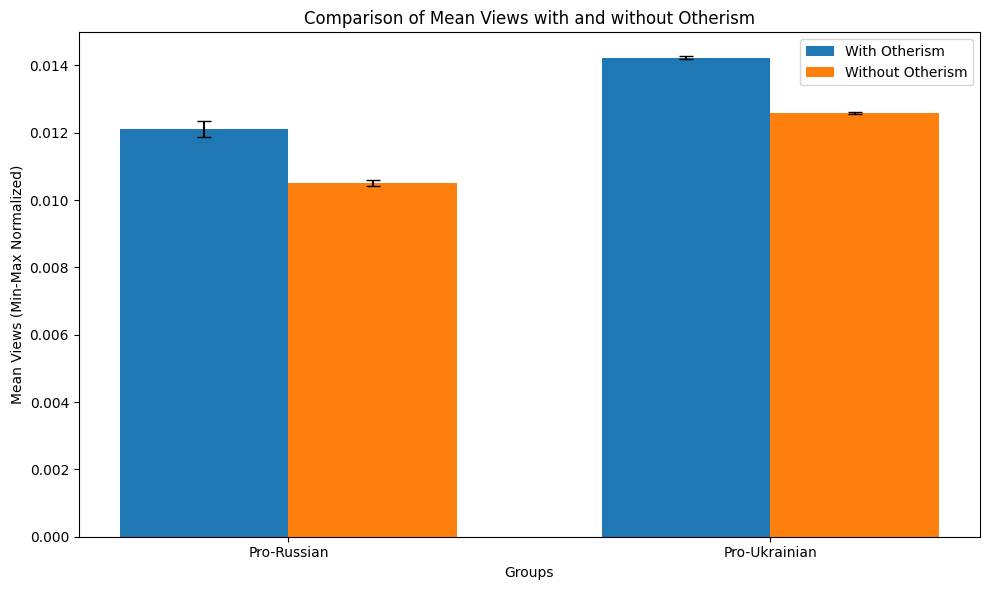

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def convert_views(views_str):
    views_str = views_str.replace(',', '')
    if 'K' in views_str:
        return float(views_str.replace('K', '')) * 1000
    elif 'M' in views_str:
        return float(views_str.replace('M', '')) * 1000000
    else:
        return float(views_str)

def check_data_integrity(data):
    # Check for missing values and data types
    print("Data types:\n", data.dtypes)
    print("\nMissing values before cleanup:\n", data.isnull().sum())
    print("\nSummary statistics before cleanup:\n", data.describe())

def remove_missing_values(data):
    # Remove rows with any missing values
    data_cleaned = data.dropna()
    print("\nMissing values after cleanup:\n", data_cleaned.isnull().sum())
    return data_cleaned

def filter_by_date(data, min_date, max_date):
    # Convert date column to datetime if not already
    data['date'] = pd.to_datetime(data['date'])
    # Filter data by the specified date range
    data_filtered = data[(data['date'] >= min_date) & (data['date'] <= max_date)]
    print(f"\nData filtered by date range ({min_date} to {max_date}) - Number of records: {len(data_filtered)}")
    return data_filtered

def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

def calculate_mann_whitney_u_test_combined(data, classes, thresholds, normalize=False):
    try:
        data['views'] = data['views'].apply(convert_views)
    except Exception as e:
        print(e)
        pass
    
    # Define otherism based on thresholds
    data['is_otherism'] = data.apply(
        lambda row: any(row[cls] >= thresholds[cls] for cls in classes), axis=1
    )
    
    # Apply min-max normalization if specified
    if normalize:
        data['views'] = min_max_normalize(data['views'])
    
    # Split into two groups: posts with otherism and without otherism
    with_otherism = data[data['is_otherism']]['views']
    without_otherism = data[~data['is_otherism']]['views']
    
    # Calculate means and standard errors
    mean_with_otherism = with_otherism.mean()
    mean_without_otherism = without_otherism.mean()
    stderr_with_otherism = with_otherism.std() / np.sqrt(len(with_otherism))
    stderr_without_otherism = without_otherism.std() / np.sqrt(len(without_otherism))
    
    # Perform Mann-Whitney U Test across all channels
    u_statistic, p_value = mannwhitneyu(with_otherism, without_otherism, alternative='two-sided')
    
    # Print results
    print(f"\nNumber of posts with otherism: {len(with_otherism)}")
    print(f"Number of posts without otherism: {len(without_otherism)}")
    print(f"Mean views with otherism: {mean_with_otherism}")
    print(f"Mean views without otherism: {mean_without_otherism}")
    
    return u_statistic, p_value, mean_with_otherism, mean_without_otherism, stderr_with_otherism, stderr_without_otherism

def plot_comparison(means_with_otherism, means_without_otherism, stderrs_with_otherism, stderrs_without_otherism, group_labels):
    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Group': group_labels,
        'With Otherism': means_with_otherism,
        'Without Otherism': means_without_otherism,
        'Stderr With Otherism': stderrs_with_otherism,
        'Stderr Without Otherism': stderrs_without_otherism
    })

    # Create a bar plot to compare means
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(group_labels))
    
    bar1 = ax.bar(index, plot_data['With Otherism'], bar_width, yerr=plot_data['Stderr With Otherism'], capsize=5, label='With Otherism')
    bar2 = ax.bar(index + bar_width, plot_data['Without Otherism'], bar_width, yerr=plot_data['Stderr Without Otherism'], capsize=5, label='Without Otherism')
    
    ax.set_xlabel('Groups')
    ax.set_ylabel('Mean Views (Min-Max Normalized)')
    ax.set_title('Comparison of Mean Views with and without Otherism')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(group_labels)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
classes = [
    'Threats to Culture or Identity', 
    'Threats to Survival or Physical Security', 
    'Vilification/Villainization',
    'Explicit Dehumanization'
]
thresholds = {
    'Threats to Culture or Identity': 0.6, 
    'Threats to Survival or Physical Security': 0.6, 
    'Vilification/Villainization': 0.6, 
    'Explicit Dehumanization': 0.6
}

# Define date range
min_date = '2022-01-01'
max_date = '2023-12-31'

# For Russian data with min-max normalization
check_data_integrity(combined_df_ru)
combined_df_ru_cleaned = remove_missing_values(combined_df_ru)
combined_df_ru_filtered = filter_by_date(combined_df_ru_cleaned, min_date, max_date)
u_statistic_ru, p_value_ru, mean_with_otherism_ru, mean_without_otherism_ru, stderr_with_otherism_ru, stderr_without_otherism_ru = calculate_mann_whitney_u_test_combined(combined_df_ru_filtered, classes, thresholds, normalize=True)

# For Ukrainian data with min-max normalization
check_data_integrity(combined_df_uk)
combined_df_uk_cleaned = remove_missing_values(combined_df_uk)
combined_df_uk_filtered = filter_by_date(combined_df_uk_cleaned, min_date, max_date)
u_statistic_uk, p_value_uk, mean_with_otherism_uk, mean_without_otherism_uk, stderr_with_otherism_uk, stderr_without_otherism_uk = calculate_mann_whitney_u_test_combined(combined_df_uk_filtered, classes, thresholds, normalize=True)

# Collect the mean views and standard errors
means_with_otherism = [mean_with_otherism_ru, mean_with_otherism_uk]
means_without_otherism = [mean_without_otherism_ru, mean_without_otherism_uk]
stderrs_with_otherism = [stderr_with_otherism_ru, stderr_with_otherism_uk]
stderrs_without_otherism = [stderr_without_otherism_ru, stderr_without_otherism_uk]
group_labels = ['Pro-Russian', 'Pro-Ukrainian']

# Plot the comparison with min-max normalized views
plot_comparison(means_with_otherism, means_without_otherism, stderrs_with_otherism, stderrs_without_otherism, group_labels)

Data types:
 user                                         object
post_id                                       int64
url                                          object
title                                        object
image_url                                    object
description                                  object
views                                        object
date                                         object
channel_name                                 object
channel_label                                object
cleaned_description                          object
cleaned_sentences                            object
Threats to Culture or Identity              float64
Threats to Survival or Physical Security    float64
Vilification/Villainization                 float64
Explicit Dehumanization                     float64
None                                        float64
classifications                              object
explanation                                  object

/tmp/ipykernel_2323784/1852088745.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])



Data filtered by date range (2022-02-08 to 2022-02-15) - Number of records: 775

Data filtered by date range (2022-02-21 to 2022-02-28) - Number of records: 1668

Data filtered by date range (2022-04-19 to 2022-04-26) - Number of records: 1743

Data filtered by date range (2022-06-01 to 2022-06-08) - Number of records: 1599

Data filtered by date range (2022-07-08 to 2022-07-15) - Number of records: 1607

Data filtered by date range (2022-08-01 to 2022-08-08) - Number of records: 1673

Data filtered by date range (2023-02-03 to 2023-02-10) - Number of records: 1781

Number of posts with otherism: 1756
Number of posts without otherism: 9090
Mean views with otherism: 0.06716978060543521
Mean views without otherism: -0.012975812402986172
Data types:
 user                                         object
post_id                                       int64
url                                          object
title                                        object
image_url                        

/tmp/ipykernel_2323784/1852088745.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])



Data filtered by date range (2022-02-08 to 2022-02-15) - Number of records: 3549

Data filtered by date range (2022-02-21 to 2022-02-28) - Number of records: 16592

Data filtered by date range (2022-03-21 to 2022-03-28) - Number of records: 15555

Data filtered by date range (2022-07-03 to 2022-07-10) - Number of records: 10532

Data filtered by date range (2022-08-29 to 2022-09-05) - Number of records: 11780

Data filtered by date range (2022-11-11 to 2022-11-18) - Number of records: 13127

Data filtered by date range (2022-12-29 to 2023-01-05) - Number of records: 10968


/tmp/ipykernel_2323784/1852088745.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_otherism'] = data.apply(



Number of posts with otherism: 22626
Number of posts without otherism: 59474
Mean views with otherism: 0.03524888725217889
Mean views without otherism: -0.013409915643269333


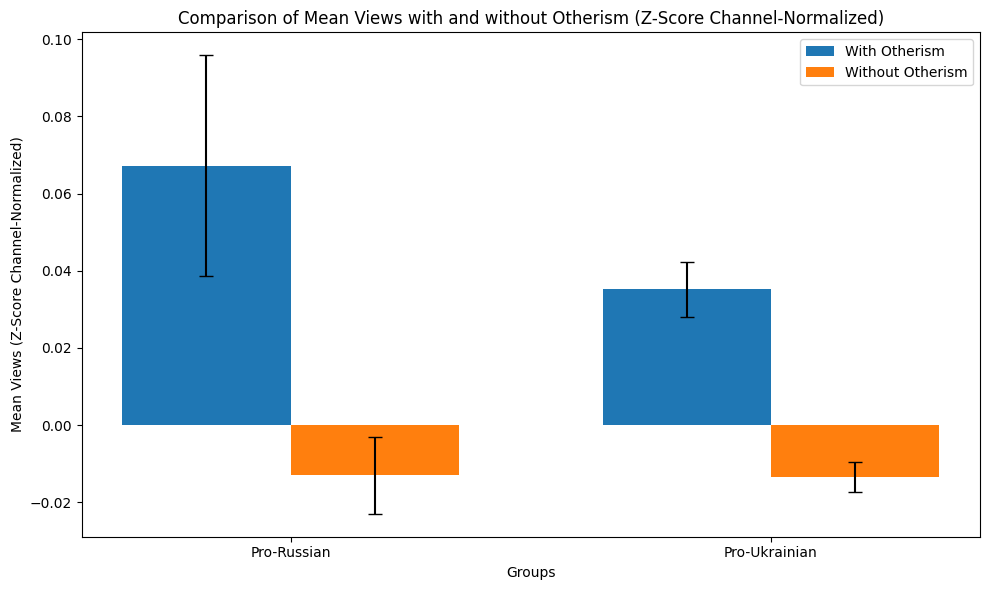

           Group  With Otherism  Without Otherism  Stderr With Otherism  \
0    Pro-Russian       0.067170         -0.012976              0.028656   
1  Pro-Ukrainian       0.035249         -0.013410              0.007124   

   Stderr Without Otherism  
0                 0.010005  
1                 0.003974  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def convert_views(views_str):
    views_str = views_str.replace(',', '')
    if 'K' in views_str:
        return float(views_str.replace('K', '')) * 1000
    elif 'M' in views_str:
        return float(views_str.replace('M', '')) * 1000000
    else:
        return float(views_str)

def check_data_integrity(data):
    # Check for missing values and data types
    print("Data types:\n", data.dtypes)
    print("\nMissing values before cleanup:\n", data.isnull().sum())
    print("\nSummary statistics before cleanup:\n", data.describe())

def remove_missing_values(data):
    # Remove rows with any missing values
    data_cleaned = data.dropna()
    print("\nMissing values after cleanup:\n", data_cleaned.isnull().sum())
    return data_cleaned

def filter_by_date(data, min_date, max_date):
    # Convert date column to datetime if not already
    data['date'] = pd.to_datetime(data['date'])
    # Filter data by the specified date range
    data_filtered = data[(data['date'] >= min_date) & (data['date'] <= max_date)]
    print(f"\nData filtered by date range ({min_date} to {max_date}) - Number of records: {len(data_filtered)}")
    return data_filtered

def min_max_normalize_per_channel(data):
    # Min-max normalization within each channel
    data['views_normalized'] = data.groupby('channel_name')['views'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )
    return data

def z_score_normalize_per_channel(data):
    # Z-score normalization within each channel
    data['views_normalized'] = data.groupby('channel_name')['views'].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
    )
    return data

def calculate_mann_whitney_u_test_channel_normalized(data, classes, thresholds, normalize=None):
    try:
        data['views'] = data['views'].apply(convert_views)
    except Exception as e:
        print(e)
        pass
    
    # Apply channel-specific normalization
    if normalize == 'min-max':
        data = min_max_normalize_per_channel(data)
    elif normalize == 'z-score':
        data = z_score_normalize_per_channel(data)
    
    # Remove NaN values in normalized views
    data = data.dropna(subset=['views_normalized'])
    
    # Define otherism based on thresholds
    data['is_otherism'] = data.apply(
        lambda row: any(row[cls] >= thresholds[cls] for cls in classes), axis=1
    )
    
    # Split into two groups: posts with otherism and without otherism
    with_otherism = data[data['is_otherism']]['views_normalized']
    without_otherism = data[~data['is_otherism']]['views_normalized']
    
    # Check the lengths of the groups
    if len(with_otherism) == 0 or len(without_otherism) == 0:
        print("One of the groups is empty. Mann-Whitney U test cannot be performed.")
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    # Calculate means and standard errors
    mean_with_otherism = with_otherism.mean()
    mean_without_otherism = without_otherism.mean()
    stderr_with_otherism = with_otherism.std() / np.sqrt(len(with_otherism))
    stderr_without_otherism = without_otherism.std() / np.sqrt(len(without_otherism))
    
    # Perform Mann-Whitney U Test across all channels
    u_statistic, p_value = mannwhitneyu(with_otherism, without_otherism, alternative='two-sided')
    
    # Print results
    print(f"\nNumber of posts with otherism: {len(with_otherism)}")
    print(f"Number of posts without otherism: {len(without_otherism)}")
    print(f"Mean views with otherism: {mean_with_otherism}")
    print(f"Mean views without otherism: {mean_without_otherism}")
    
    return u_statistic, p_value, mean_with_otherism, mean_without_otherism, stderr_with_otherism, stderr_without_otherism

def plot_comparison_channel_normalized(means_with_otherism, means_without_otherism, stderrs_with_otherism, stderrs_without_otherism, group_labels, normalization_type):
    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Group': group_labels,
        'With Otherism': means_with_otherism,
        'Without Otherism': means_without_otherism,
        'Stderr With Otherism': stderrs_with_otherism,
        'Stderr Without Otherism': stderrs_without_otherism
    })

    # Create a bar plot to compare means
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(group_labels))
    
    bar1 = ax.bar(index, plot_data['With Otherism'], bar_width, yerr=plot_data['Stderr With Otherism'], capsize=5, label='With Otherism')
    bar2 = ax.bar(index + bar_width, plot_data['Without Otherism'], bar_width, yerr=plot_data['Stderr Without Otherism'], capsize=5, label='Without Otherism')
    
    ax.set_xlabel('Groups')
    ax.set_ylabel(f'Mean Views ({normalization_type} Channel-Normalized)')
    ax.set_title(f'Comparison of Mean Views with and without Otherism ({normalization_type} Channel-Normalized)')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(group_labels)
    ax.legend()

    plt.tight_layout()
    plt.show()

    return plot_data

# Example usage:
classes = [
    'Threats to Culture or Identity', 
    'Threats to Survival or Physical Security', 
    'Vilification/Villainization',
    'Explicit Dehumanization'
]
thresholds = {
    'Threats to Culture or Identity': 0.6, 
    'Threats to Survival or Physical Security': 0.6, 
    'Vilification/Villainization': 0.6, 
    'Explicit Dehumanization': 0.6
}

# Define date range
min_date = '2022-01-01'
max_date = '2022-04-29'




def filter_by_date_ranges(data, date_ranges):
    # Convert date column to datetime if not already
    data['date'] = pd.to_datetime(data['date'])
    
    # Initialize an empty DataFrame to store filtered data
    filtered_data = pd.DataFrame()

    # Loop through each date range and filter the data
    for min_date, max_date in date_ranges:
        data_filtered = data[(data['date'] >= min_date) & (data['date'] <= max_date)]
        print(f"\nData filtered by date range ({min_date} to {max_date}) - Number of records: {len(data_filtered)}")
        filtered_data = pd.concat([filtered_data, data_filtered], ignore_index=True)
    
    return filtered_data

# Example usage:
# combined_df_both_filtered = filter_by_date_ranges(combined_df_both_cleaned, date_ranges)



# For Russian data with z-score channel normalization
check_data_integrity(combined_df_ru)
combined_df_ru_cleaned = remove_missing_values(combined_df_ru)


date_ranges_ru = [
    ('2022-02-08', '2022-02-15'),
    ('2022-02-21', '2022-02-28'),
    ('2022-04-19', '2022-04-26'),
    ('2022-06-01', '2022-06-08'),
    ('2022-07-08', '2022-07-15'),
    ('2022-08-01', '2022-08-08'),
    ('2023-02-03', '2023-02-10'),
]

# Apply the filter to the combined dataset
combined_df_ru_filtered = filter_by_date_ranges(combined_df_ru_cleaned, date_ranges_ru)
# combined_df_ru_filtered = filter_by_date(combined_df_ru_cleaned, min_date, max_date)
u_statistic_ru, p_value_ru, mean_with_otherism_ru, mean_without_otherism_ru, stderr_with_otherism_ru, stderr_without_otherism_ru = calculate_mann_whitney_u_test_channel_normalized(combined_df_ru_filtered, classes, thresholds, normalize='z-score')

date_ranges_uk = [
    ('2022-02-08', '2022-02-15'),
    ('2022-02-21', '2022-02-28'),
    ('2022-03-21', '2022-03-28'),
    ('2022-07-03', '2022-07-10'),
    ('2022-08-29', '2022-09-05'),
    ('2022-11-11', '2022-11-18'),
    ('2022-12-29', '2023-01-05'),
]
# For Ukrainian data with z-score channel normalization
# Define date range
# min_date = '2022-01-01'
# max_date = '2022-04-29'
check_data_integrity(combined_df_uk)
combined_df_uk_cleaned = remove_missing_values(combined_df_uk)
# combined_df_uk_filtered = filter_by_date(combined_df_uk_cleaned, min_date, max_date)
combined_df_uk_filtered = filter_by_date_ranges(combined_df_uk_cleaned, date_ranges_uk)
u_statistic_uk, p_value_uk, mean_with_otherism_uk, mean_without_otherism_uk, stderr_with_otherism_uk, stderr_without_otherism_uk = calculate_mann_whitney_u_test_channel_normalized(combined_df_uk_filtered, classes, thresholds, normalize='z-score')

# For the combined data, ensure you normalize the entire dataset again
# combined_df = pd.concat([combined_df_ru, combined_df_uk], ignore_index=True)

# # Normalize and calculate metrics for the combined dataset
# check_data_integrity(combined_df)
# combined_df_both_cleaned = remove_missing_values(combined_df)
# combined_df_both_filtered = filter_by_date(combined_df_both_cleaned, min_date, max_date)
# u_statistic_both, p_value_both, mean_with_otherism_both, mean_without_otherism_both, stderr_with_otherism_both, stderr_without_otherism_both = calculate_mann_whitney_u_test_channel_normalized(combined_df_both_filtered, classes, thresholds, normalize='z-score')

# Collect the mean views and standard errors
means_with_otherism = [mean_with_otherism_ru, mean_with_otherism_uk]
means_without_otherism = [mean_without_otherism_ru, mean_without_otherism_uk]
stderrs_with_otherism = [stderr_with_otherism_ru, stderr_with_otherism_uk]
stderrs_without_otherism = [stderr_without_otherism_ru, stderr_without_otherism_uk]
group_labels = ['Pro-Russian', 'Pro-Ukrainian']
# means_with_otherism = [mean_with_otherism_both, mean_with_otherism_ru, mean_with_otherism_uk]
# means_without_otherism = [mean_without_otherism_both, mean_without_otherism_ru, mean_without_otherism_uk]
# stderrs_with_otherism = [stderr_with_otherism_both, stderr_with_otherism_ru, stderr_with_otherism_uk]
# stderrs_without_otherism = [stderr_without_otherism_both, stderr_without_otherism_ru, stderr_without_otherism_uk]
# group_labels = ['Both', 'Pro-Russian', 'Pro-Ukrainian']

# Plot the comparison with z-score normalized views
plot_data_df = plot_comparison_channel_normalized(means_with_otherism, means_without_otherism, stderrs_with_otherism, stderrs_without_otherism, group_labels, normalization_type='Z-Score')

# Return the DataFrame for further use, such as uploading to Overleaf
print(plot_data_df)

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def convert_views(views_str):
    views_str = views_str.replace(',', '')
    if 'K' in views_str:
        return float(views_str.replace('K', '')) * 1000
    elif 'M' in views_str:
        return float(views_str.replace('M', '')) * 1000000
    else:
        return float(views_str)

def check_data_integrity(data):
    # Check for missing values and data types
    print("Data types:\n", data.dtypes)
    print("\nMissing values before cleanup:\n", data.isnull().sum())
    print("\nSummary statistics before cleanup:\n", data.describe())

def remove_missing_values(data):
    # Remove rows with any missing values
    data_cleaned = data.dropna()
    print("\nMissing values after cleanup:\n", data_cleaned.isnull().sum())
    return data_cleaned

def filter_by_date(data, min_date, max_date):
    # Convert date column to datetime if not already
    data['date'] = pd.to_datetime(data['date'])
    # Filter data by the specified date range
    data_filtered = data[(data['date'] >= min_date) & (data['date'] <= max_date)]
    print(f"\nData filtered by date range ({min_date} to {max_date}) - Number of records: {len(data_filtered)}")
    return data_filtered

def min_max_normalize_per_channel(data):
    # Min-max normalization within each channel
    data['views_normalized'] = data.groupby('channel_name')['views'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )
    return data

def z_score_normalize_per_channel(data):
    # Z-score normalization within each channel
    data['views_normalized'] = data.groupby('channel_name')['views'].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
    )
    return data

def calculate_mann_whitney_u_test_channel_normalized(data, classes, thresholds, normalize=None):
    try:
        data['views'] = data['views'].apply(convert_views)
    except Exception as e:
        print(e)
        pass
    
    # Apply channel-specific normalization
    if normalize == 'min-max':
        data = min_max_normalize_per_channel(data)
    elif normalize == 'z-score':
        data = z_score_normalize_per_channel(data)
    
    # Remove NaN values in normalized views
    data = data.dropna(subset=['views_normalized'])
    
    # Define otherism based on thresholds
    data['is_otherism'] = data.apply(
        lambda row: any(row[cls] >= thresholds[cls] for cls in classes), axis=1
    )
    
    # Split into two groups: posts with otherism and without otherism
    with_otherism = data[data['is_otherism']]['views_normalized']
    without_otherism = data[~data['is_otherism']]['views_normalized']
    
    # Check the lengths of the groups
    if len(with_otherism) == 0 or len(without_otherism) == 0:
        print("One of the groups is empty. Mann-Whitney U test cannot be performed.")
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    # Calculate means and standard errors
    mean_with_otherism = with_otherism.mean()
    mean_without_otherism = without_otherism.mean()
    stderr_with_otherism = with_otherism.std() / np.sqrt(len(with_otherism))
    stderr_without_otherism = without_otherism.std() / np.sqrt(len(without_otherism))
    
    # Perform Mann-Whitney U Test across all channels
    u_statistic, p_value = mannwhitneyu(with_otherism, without_otherism, alternative='two-sided')
    
    # Print results
    print(f"\nNumber of posts with otherism: {len(with_otherism)}")
    print(f"Number of posts without otherism: {len(without_otherism)}")
    print(f"Mean views with otherism: {mean_with_otherism}")
    print(f"Mean views without otherism: {mean_without_otherism}")
    
    return u_statistic, p_value, mean_with_otherism, mean_without_otherism, stderr_with_otherism, stderr_without_otherism

def plot_comparison_channel_normalized(means_with_otherism, means_without_otherism, stderrs_with_otherism, stderrs_without_otherism, group_labels, normalization_type):
    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Group': group_labels,
        'With Otherism': means_with_otherism,
        'Without Otherism': means_without_otherism,
        'Stderr With Otherism': stderrs_with_otherism,
        'Stderr Without Otherism': stderrs_without_otherism
    })

    # Create a bar plot to compare means
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(group_labels))
    
    bar1 = ax.bar(index, plot_data['With Otherism'], bar_width, yerr=plot_data['Stderr With Otherism'], capsize=5, label='With Otherism')
    bar2 = ax.bar(index + bar_width, plot_data['Without Otherism'], bar_width, yerr=plot_data['Stderr Without Otherism'], capsize=5, label='Without Otherism')
    
    ax.set_xlabel('Groups')
    ax.set_ylabel(f'Mean Views ({normalization_type} Channel-Normalized)')
    ax.set_title(f'Comparison of Mean Views with and without Otherism ({normalization_type} Channel-Normalized)')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(group_labels)
    ax.legend()

    plt.tight_layout()
    plt.show()

    return plot_data

# Example usage:
classes = [
    'Threats to Culture or Identity', 
    'Threats to Survival or Physical Security', 
    'Vilification/Villainization',
    'Explicit Dehumanization'
]
thresholds = {
    'Threats to Culture or Identity': 0.6, 
    'Threats to Survival or Physical Security': 0.6, 
    'Vilification/Villainization': 0.6, 
    'Explicit Dehumanization': 0.6
}

# Define date range
min_date = '2022-01-01'
max_date = '2023-12-31'

# For Ukrainian data with z-score channel normalization
check_data_integrity(combined_df_uk)
combined_df_uk_cleaned = remove_missing_values(combined_df_uk)
combined_df_uk_filtered = filter_by_date(combined_df_uk_cleaned, min_date, max_date)
u_statistic_uk, p_value_uk, mean_with_otherism_uk, mean_without_otherism_uk, stderr_with_otherism_uk, stderr_without_otherism_uk = calculate_mann_whitney_u_test_channel_normalized(combined_df_uk_filtered, classes, thresholds, normalize='z-score')
u_statistic_uk, p_value_uk, mean_with_otherism_uk, mean_without_otherism_uk, stderr_with_otherism_uk, 

Data types:
 user                                         object
post_id                                       int64
url                                          object
title                                        object
image_url                                    object
description                                  object
views                                        object
date                                         object
channel_name                                 object
channel_label                                object
cleaned_description                          object
cleaned_sentences                            object
classifications                              object
explanation                                  object
Threats to Culture or Identity              float64
Threats to Survival or Physical Security    float64
Vilification/Villainization                 float64
Explicit Dehumanization                     float64
None                                        float64

/tmp/ipykernel_118709/3197263915.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])



Data filtered by date range (2022-01-01 to 2023-12-31) - Number of records: 767476


/tmp/ipykernel_118709/3197263915.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views'] = data['views'].apply(convert_views)
/tmp/ipykernel_118709/3197263915.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views_normalized'] = data.groupby('channel_name')['views'].transform(
/tmp/ipykernel_118709/3197263915.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d


Number of posts with otherism: 194749
Number of posts without otherism: 572726
Mean views with otherism: 0.013367843356720277
Mean views without otherism: -0.004545583971878212


(55314675136.0,
 7.529293212319811e-08,
 0.013367843356720277,
 -0.004545583971878212,
 0.002435574017716547)

In [39]:
u_statistic_both, p_value_both, mean_with_otherism_both, mean_without_otherism_both, stderr_with_otherism_both

(1226288675.5,
 5.3031466208156684e-58,
 0.09401512781608384,
 -0.019732935424514174,
 0.00915622381983699)

In [40]:
u_statistic_uk, p_value_uk, mean_with_otherism_uk, mean_without_otherism_uk, stderr_with_otherism_uk, stderr_without_otherism_uk 


(55314675136.0,
 7.529293212319811e-08,
 0.013367843356720277,
 -0.004545583971878212,
 0.002435574017716547,
 0.001285694951818988)

In [41]:
u_statistic_ru, p_value_ru, mean_with_otherism_ru, mean_without_otherism_ru, stderr_with_otherism_ru, stderr_without_otherism_ru

(1226288675.5,
 5.3031466208156684e-58,
 0.09401512781608384,
 -0.019732935424514174,
 0.00915622381983699,
 0.0028023775916430093)

In [25]:
plot_data_df.to_csv('/nas/home/pgerard/eclair_jupyter/otherism_paper/overleaf_plots/ukrainain_russian_views.csv')

Data types:
 user                                         object
post_id                                       int64
url                                          object
title                                        object
image_url                                    object
description                                  object
views                                        object
date                                         object
channel_name                                 object
channel_label                                object
cleaned_description                          object
cleaned_sentences                            object
Threats to Culture or Identity              float64
Threats to Survival or Physical Security    float64
Vilification/Villainization                 float64
Explicit Dehumanization                     float64
None                                        float64
classifications                              object
explanation                                  object

/tmp/ipykernel_118709/4053020029.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
/tmp/ipykernel_118709/4053020029.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views'] = data['views'].apply(convert_views)
/tmp/ipykernel_118709/4053020029.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd


Data filtered by date range (2022-01-01 to 2023-12-31) - Number of records: 126505


/tmp/ipykernel_118709/4053020029.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_otherism'] = data.apply(



Number of posts with otherism: 21946
Number of posts without otherism: 104559
Mean views with otherism (per-channel normalized): 0.03631646778829889
Mean views without otherism (per-channel normalized): 0.03568702833325
Data types:
 user                                         object
post_id                                       int64
url                                          object
title                                        object
image_url                                    object
description                                  object
views                                        object
date                                         object
channel_name                                 object
channel_label                                object
cleaned_description                          object
cleaned_sentences                            object
classifications                              object
explanation                                  object
Threats to Culture or Identity        

/tmp/ipykernel_118709/4053020029.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])



Data filtered by date range (2022-01-01 to 2023-12-31) - Number of records: 767476


/tmp/ipykernel_118709/4053020029.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views'] = data['views'].apply(convert_views)
/tmp/ipykernel_118709/4053020029.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['views_normalized'] = data.groupby('channel_name')['views'].transform(
/tmp/ipykernel_118709/4053020029.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d


Number of posts with otherism: 194750
Number of posts without otherism: 572726
Mean views with otherism (per-channel normalized): 0.1416099116291189
Mean views without otherism (per-channel normalized): 0.1450124487700591


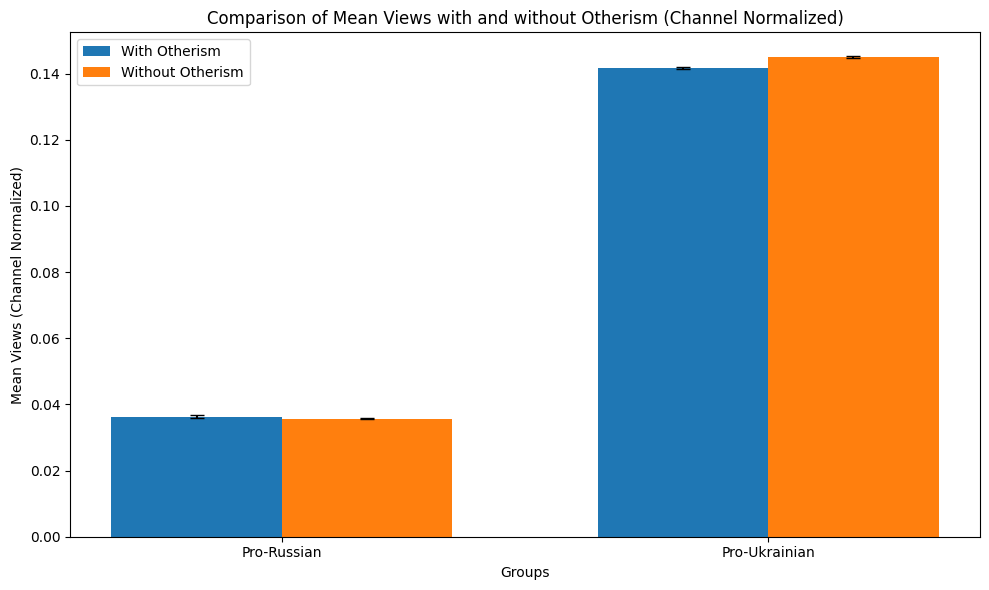

           Group  With Otherism  Without Otherism  Stderr With Otherism  \
0    Pro-Russian       0.036316          0.035687              0.000539   
1  Pro-Ukrainian       0.141610          0.145012              0.000300   

   Stderr Without Otherism  
0                 0.000234  
1                 0.000181  


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def convert_views(views_str):
    views_str = views_str.replace(',', '')
    if 'K' in views_str:
        return float(views_str.replace('K', '')) * 1000
    elif 'M' in views_str:
        return float(views_str.replace('M', '')) * 1000000
    else:
        return float(views_str)

def check_data_integrity(data):
    # Check for missing values and data types
    print("Data types:\n", data.dtypes)
    print("\nMissing values before cleanup:\n", data.isnull().sum())
    print("\nSummary statistics before cleanup:\n", data.describe())

def remove_missing_values(data):
    # Remove rows with any missing values
    data_cleaned = data.dropna()
    print("\nMissing values after cleanup:\n", data_cleaned.isnull().sum())
    return data_cleaned

def filter_by_date(data, min_date, max_date):
    # Convert date column to datetime if not already
    data['date'] = pd.to_datetime(data['date'])
    # Filter data by the specified date range
    data_filtered = data[(data['date'] >= min_date) & (data['date'] <= max_date)]
    print(f"\nData filtered by date range ({min_date} to {max_date}) - Number of records: {len(data_filtered)}")
    return data_filtered

def normalize_views_per_channel(data):
    # Normalize views within each channel to [0, 1] range
    data['views_normalized'] = data.groupby('channel_name')['views'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )
    return data

def calculate_mann_whitney_u_test_channel_normalized(data, classes, thresholds):
    try:
        data['views'] = data['views'].apply(convert_views)
    except Exception as e:
        print(e)
        pass
    
    # Normalize views per channel
    data = normalize_views_per_channel(data)
    
    # Define otherism based on thresholds
    data['is_otherism'] = data.apply(
        lambda row: any(row[cls] >= thresholds[cls] for cls in classes), axis=1
    )
    
    # Split into two groups: posts with otherism and without otherism
    with_otherism = data[data['is_otherism']]['views_normalized']
    without_otherism = data[~data['is_otherism']]['views_normalized']
    
    # Calculate means and standard errors
    mean_with_otherism = with_otherism.mean()
    mean_without_otherism = without_otherism.mean()
    stderr_with_otherism = with_otherism.std() / np.sqrt(len(with_otherism))
    stderr_without_otherism = without_otherism.std() / np.sqrt(len(without_otherism))
    
    # Perform Mann-Whitney U Test across all channels
    u_statistic, p_value = mannwhitneyu(with_otherism, without_otherism, alternative='two-sided')
    
    # Print results
    print(f"\nNumber of posts with otherism: {len(with_otherism)}")
    print(f"Number of posts without otherism: {len(without_otherism)}")
    print(f"Mean views with otherism (per-channel normalized): {mean_with_otherism}")
    print(f"Mean views without otherism (per-channel normalized): {mean_without_otherism}")
    
    return u_statistic, p_value, mean_with_otherism, mean_without_otherism, stderr_with_otherism, stderr_without_otherism, with_otherism, without_otherism

def plot_comparison_channel_normalized(means_with_otherism, means_without_otherism, stderrs_with_otherism, stderrs_without_otherism, group_labels):
    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Group': group_labels,
        'With Otherism': means_with_otherism,
        'Without Otherism': means_without_otherism,
        'Stderr With Otherism': stderrs_with_otherism,
        'Stderr Without Otherism': stderrs_without_otherism
    })

    # Create a bar plot to compare means
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(group_labels))
    
    bar1 = ax.bar(index, plot_data['With Otherism'], bar_width, yerr=plot_data['Stderr With Otherism'], capsize=5, label='With Otherism')
    bar2 = ax.bar(index + bar_width, plot_data['Without Otherism'], bar_width, yerr=plot_data['Stderr Without Otherism'], capsize=5, label='Without Otherism')
    
    ax.set_xlabel('Groups')
    ax.set_ylabel('Mean Views (Channel Normalized)')
    ax.set_title('Comparison of Mean Views with and without Otherism (Channel Normalized)')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(group_labels)
    ax.legend()

    plt.tight_layout()
    plt.show()

    return plot_data

# Example usage:
classes = [
    'Threats to Culture or Identity', 
    'Threats to Survival or Physical Security', 
    'Vilification/Villainization',
    'Explicit Dehumanization'
]
thresholds = {
    'Threats to Culture or Identity': 0.6, 
    'Threats to Survival or Physical Security': 0.6, 
    'Vilification/Villainization': 0.6, 
    'Explicit Dehumanization': 0.6
}

# Define date range
min_date = '2022-01-01'
max_date = '2023-12-31'

# For Russian data with channel normalization
check_data_integrity(combined_df_ru)
combined_df_ru_cleaned = remove_missing_values(combined_df_ru)
combined_df_ru_filtered = filter_by_date(combined_df_ru_cleaned, min_date, max_date)
u_statistic_ru, p_value_ru, mean_with_otherism_ru, mean_without_otherism_ru, stderr_with_otherism_ru, stderr_without_otherism_ru, _, _ = calculate_mann_whitney_u_test_channel_normalized(combined_df_ru_filtered, classes, thresholds)

# For Ukrainian data with channel normalization
check_data_integrity(combined_df_uk)
combined_df_uk_cleaned = remove_missing_values(combined_df_uk)
combined_df_uk_filtered = filter_by_date(combined_df_uk_cleaned, min_date, max_date)
u_statistic_uk, p_value_uk, mean_with_otherism_uk, mean_without_otherism_uk, stderr_with_otherism_uk, stderr_without_otherism_uk, _, _ = calculate_mann_whitney_u_test_channel_normalized(combined_df_uk_filtered, classes, thresholds)

# Collect the mean views and standard errors
means_with_otherism = [mean_with_otherism_ru, mean_with_otherism_uk]
means_without_otherism = [mean_without_otherism_ru, mean_without_otherism_uk]
stderrs_with_otherism = [stderr_with_otherism_ru, stderr_with_otherism_uk]
stderrs_without_otherism = [stderr_without_otherism_ru, stderr_without_otherism_uk]
group_labels = ['Pro-Russian', 'Pro-Ukrainian']

# Plot the comparison with channel normalized views and return the DataFrame
plot_data_df = plot_comparison_channel_normalized(means_with_otherism, means_without_otherism, stderrs_with_otherism, stderrs_without_otherism, group_labels)

# Return the DataFrame for further use, such as uploading to Overleaf
print(plot_data_df)


In [14]:
u_statistic_uk, p_value_uk, mean_with_otherism_uk, mean_without_otherism_uk

(nan, nan, nan, nan)

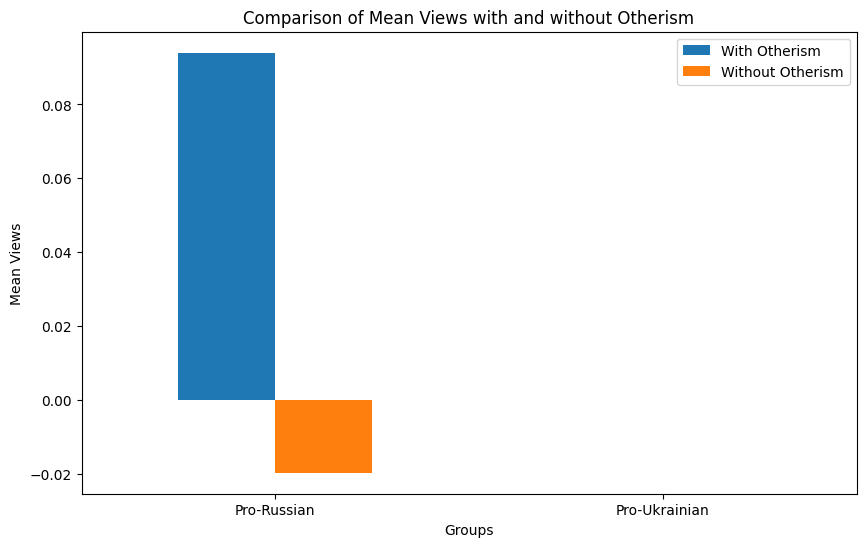

In [13]:
def plot_comparison(means_with_otherism, means_without_otherism, group_labels):
    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Group': group_labels,
        'With Otherism': means_with_otherism,
        'Without Otherism': means_without_otherism
    })

    # Create a bar plot to compare means
    plot_data.plot(kind='bar', x='Group', stacked=False, figsize=(10, 6))
    plt.title('Comparison of Mean Views with and without Otherism')
    plt.ylabel('Mean Views')
    plt.xlabel('Groups')
    plt.xticks(rotation=0)
    plt.legend(['With Otherism', 'Without Otherism'])
    plt.show()
    
means_with_otherism = [mean_with_otherism, mean_with_otherism_uk]
means_without_otherism = [mean_without_otherism, mean_without_otherism_uk]
group_labels = ['Pro-Russian', 'Pro-Ukrainian']

# Plot the comparison
plot_comparison(means_with_otherism, means_without_otherism, group_labels)


In inflamed environments, casting the 'enemy' as the outcast is rewarded.
Otherist things -- people tend to get more views when they spew bad things and people tend to be more central
- this is particularly the case following major events -- people get more views --> this supports the idea that those that say bad things tend to THEN attract more viewership in a hyper-othered environemnt

morality and otherism are concomitant in language; moral values are strongly implicated in intergroup prejudice
- see it more in russian texts

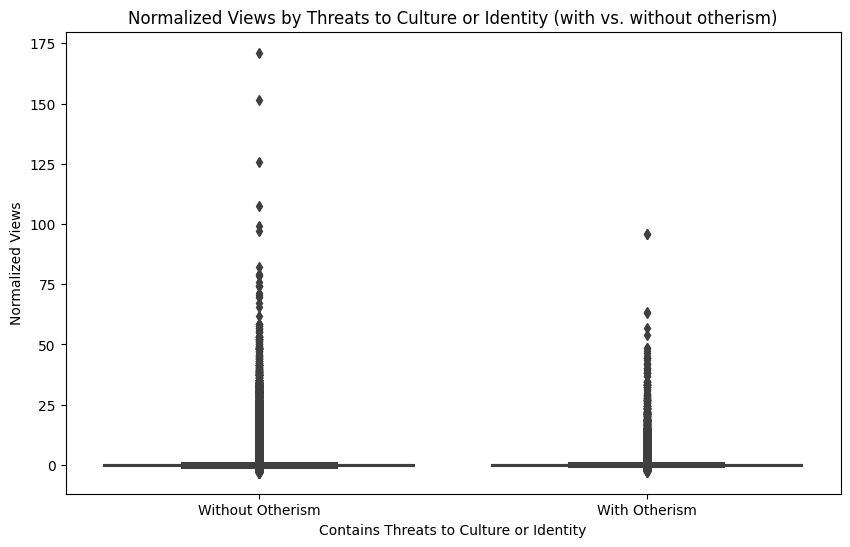

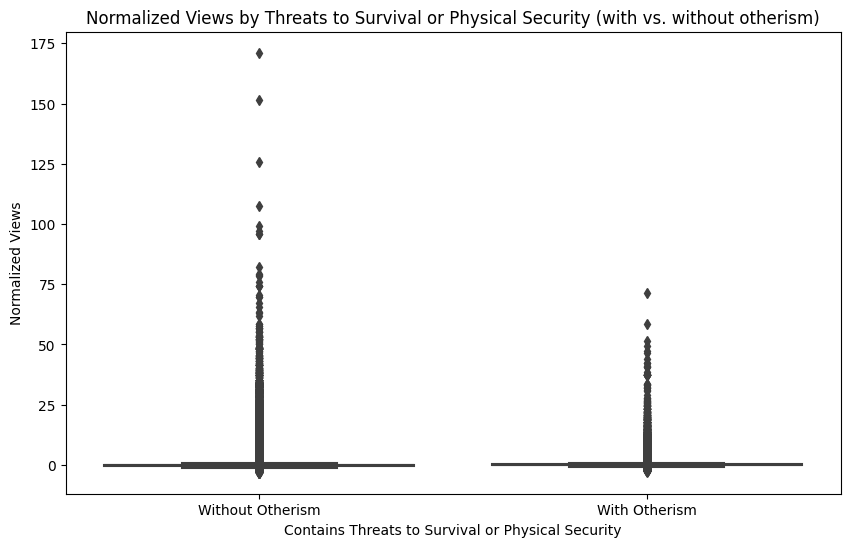

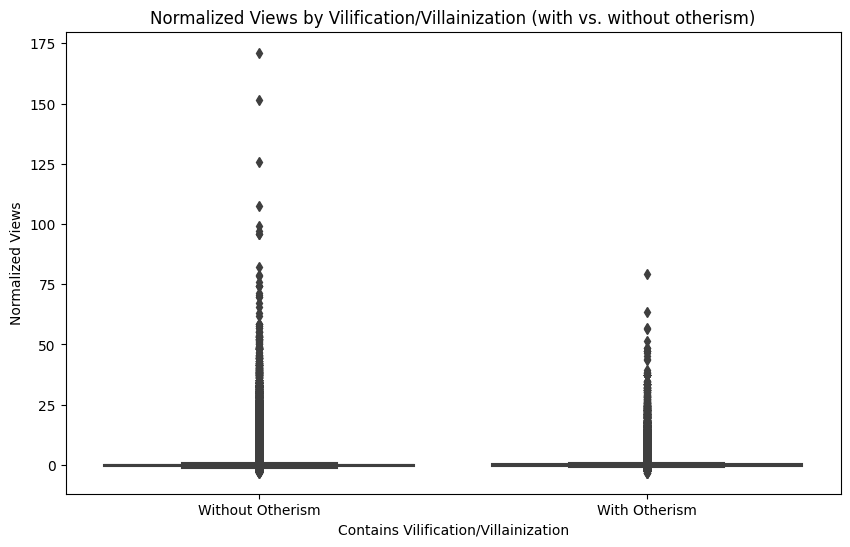

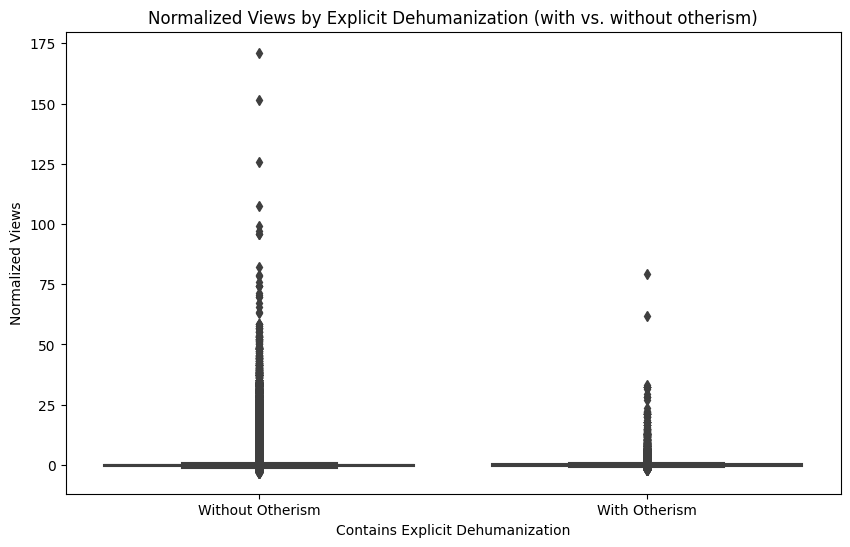

                                      class  u_statistic  p_value  \
0            Threats to Culture or Identity          NaN      NaN   
1  Threats to Survival or Physical Security          NaN      NaN   
2               Vilification/Villainization          NaN      NaN   
3                   Explicit Dehumanization          NaN      NaN   

   mean_views_with_otherism  mean_views_without_otherism  n_with_otherism  \
0                  0.059374                    -0.004586           355015   
1                  0.124919                    -0.007486           279927   
2                  0.113890                    -0.011083           439058   
3                  0.082627                    -0.000985            58337   

   n_without_otherism  
0             4595899  
1             4670987  
2             4511856  
3             4892577  
Number of otherism classes with significant difference in views: 0


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def normalize_views_per_channel(data):
    # Normalize views within each channel
    data['views_normalized'] = data.groupby('channel_name')['views'].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    return data

def calculate_mann_whitney_u_test_per_class(data, classes, thresholds):
    results = []
    
    # Normalize views within each channel
    data = normalize_views_per_channel(data)
    
    for cls in classes:
        # Create a binary indicator for whether the post meets the otherism threshold for the specific class
        data['is_otherism'] = data[cls] >= thresholds[cls]
        
        # Split into two groups: posts with otherism and without otherism
        with_otherism = data[data['is_otherism']]['views_normalized']
        without_otherism = data[~data['is_otherism']]['views_normalized']
        
        # Perform Mann-Whitney U Test
        if len(with_otherism) > 0 and len(without_otherism) > 0:
            u_statistic, p_value = mannwhitneyu(with_otherism, without_otherism, alternative='two-sided')
            results.append({
                'class': cls,
                'u_statistic': u_statistic,
                'p_value': p_value,
                'mean_views_with_otherism': with_otherism.mean(),
                'mean_views_without_otherism': without_otherism.mean(),
                'n_with_otherism': len(with_otherism),
                'n_without_otherism': len(without_otherism)
            })
            
            # Visualize the data
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=data, x='is_otherism', y='views_normalized')
            plt.title(f'Normalized Views by {cls} (with vs. without otherism)')
            plt.xlabel(f'Contains {cls}')
            plt.ylabel('Normalized Views')
            plt.xticks([0, 1], ['Without Otherism', 'With Otherism'])
            plt.show()
    
    results_df = pd.DataFrame(results)
    return results_df

# Example usage:
classes = [
    'Threats to Culture or Identity', 
    'Threats to Survival or Physical Security', 
    'Vilification/Villainization',
    'Explicit Dehumanization'
]
thresholds = {
    'Threats to Culture or Identity': 0.6, 
    'Threats to Survival or Physical Security': 0.6, 
    'Vilification/Villainization': 0.6, 
    'Explicit Dehumanization': 0.6
}

# Run the analysis and visualize the results
results_df = calculate_mann_whitney_u_test_per_class(combined_df_ru, classes, thresholds)

# Display the results
print(results_df)

# Check how many classes show a significant difference
significant_results = results_df[results_df['p_value'] < 0.05]
print(f"Number of otherism classes with significant difference in views: {len(significant_results)}")


In [37]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain

from networkx.algorithms.community.quality import modularity
# import networkx as nx
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# import community as community_louvain
# from tqdm import tqdm

# Enable progress_apply for pandas
tqdm.pandas()

def analyze_node_with_neighbors_regression(graph_path, combined_df, classes, thresholds, min_date, max_date, n_neighbors=3):
    """
    Analyze the relationship between each node's otherism proportion and the average otherism proportion 
    of its `n` nearest neighbors using OLS regression.
    
    Parameters:
    - graph_path: Path to the .graphml file containing the network.
    - combined_df: DataFrame containing channel names and otherism data.
    - classes: List of otherism categories to combine.
    - thresholds: Dictionary containing thresholds for each otherism category.
    - min_date: Minimum date for filtering the combined_df.
    - max_date: Maximum date for filtering the combined_df.
    - n_neighbors: Number of nearest neighbors to consider for each node.
    
    Returns:
    - OLS regression summary.
    """
    # Load the graph
    G = nx.read_graphml(graph_path)
    
    # Convert the graph to undirected
    G = G.to_undirected()
    
    # Filter combined_df by date
    combined_df['date'] = pd.to_datetime(combined_df['date'])  # Ensure date column is datetime
    filtered_df = combined_df[(combined_df['date'] >= min_date) & (combined_df['date'] <= max_date)].copy()
    
    # Calculate the combined proportion for the specified classes
    def calculate_combined_proportion(x):
        combined_score = sum((x[category] >= thresholds[category]).astype(int) for category in classes)
        return combined_score.sum() / len(x)
    
    # Apply the function with progress bar
    proportions_df = filtered_df.groupby('channel_name').progress_apply(
        lambda x: pd.Series({
            'combined_proportion': calculate_combined_proportion(x),
            'otherism_w-1': calculate_combined_proportion(x.shift(1).fillna(0)),  # Shift by 1 week
            'otherism_w-2': calculate_combined_proportion(x.shift(2).fillna(0))  # Shift by 2 weeks
        })
    ).reset_index()
    
    # Add the combined proportion as a node attribute in the graph
    for index, row in proportions_df.iterrows():
        if row['channel_name'] in G.nodes:
            G.nodes[row['channel_name']]['combined_otherism_proportion'] = row['combined_proportion']
            G.nodes[row['channel_name']]['otherism_w-1'] = row['otherism_w-1']
            G.nodes[row['channel_name']]['otherism_w-2'] = row['otherism_w-2']
    
    results = []
    
    # Calculate eigenvector centrality for all nodes
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    
    # For each node, calculate the average otherism proportion of its `n` nearest neighbors
    for node in G.nodes:
        node_otherism_prop = G.nodes[node].get('combined_otherism_proportion', 0)
        node_centrality = eigenvector_centrality.get(node, 0)
        
        # Find the `n` nearest neighbors based on shortest path length
        neighbors = sorted(G.neighbors(node), key=lambda neighbor: eigenvector_centrality.get(neighbor, 0), reverse=True)
        nearest_neighbors = neighbors[:n_neighbors]
        
        if nearest_neighbors:
            neighbors_otherism_prop = pd.Series([
                G.nodes[neighbor].get('combined_otherism_proportion', 0)
                for neighbor in nearest_neighbors
            ]).mean()
        else:
            neighbors_otherism_prop = 0
        
        results.append({
            'node': node,
            'node_otherism_prop': node_otherism_prop,  # y variable
            'neighbors_otherism_prop': neighbors_otherism_prop,
            'node_centrality': node_centrality
        })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    # Prepare data for OLS regression
    X = results_df[['neighbors_otherism_prop', 'node_centrality']]
    y = results_df['node_otherism_prop']
    X = sm.add_constant(X)  # Add a constant term to the predictor
    
    # Perform OLS regression
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Print the regression summary
    print(results.summary())
    
    return results_df, results

# Example usage:
classes = [
           'Threats to Culture or Identity', 
           'Threats to Survival or Physical Security', 
           'Vilification/Villainization',
           'Explicit Dehumanization'
          ]
thresholds = {'Threats to Culture or Identity': 0.99, 'Threats to Survival or Physical Security': 0.9, 
              'Vilification/Villainization': 0.9, 'Explicit Dehumanization': 0.99}
results_df, regression_results = analyze_node_with_neighbors_regression(
    '/nas/eclairnas01/users/pgerard/df_ru_with_mentions/russian_graph.graphml', 
    combined_df_ru, classes, thresholds, '2022-02-16', '2024-03-19', n_neighbors=3
)

# Display the resulting DataFrame
print(results_df)


100%|██████████| 310/310 [00:21<00:00, 14.28it/s]

                            OLS Regression Results                            
Dep. Variable:     node_otherism_prop   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     91.93
Date:                Sat, 24 Aug 2024   Prob (F-statistic):           2.87e-38
Time:                        20:02:18   Log-Likelihood:                 2847.8
No. Observations:                1422   AIC:                            -5690.
Df Residuals:                    1419   BIC:                            -5674.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [35]:
import networkx as nx
import pandas as pd
import numpy as np
import statsmodels.api as sm
import community.community_louvain as community_louvain
from tqdm import tqdm

# Enable progress_apply for pandas
tqdm.pandas()

def analyze_otherism_with_regression(graph_path, combined_df, classes, thresholds, min_date, max_date):
    """
    Analyze the relationship between centrality and otherism in communities using OLS regression.
    
    Parameters:
    - graph_path: Path to the .graphml file containing the network.
    - combined_df: DataFrame containing channel names and otherism data.
    - classes: List of otherism categories to combine.
    - thresholds: Dictionary containing thresholds for each otherism category.
    - min_date: Minimum date for filtering the combined_df.
    - max_date: Maximum date for filtering the combined_df.
    
    Returns:
    - OLS regression summary.
    """
    # Load the graph
    G = nx.read_graphml(graph_path)
    
    # Convert the graph to undirected
    G = G.to_undirected()
    
    # Filter combined_df by date
    combined_df['date'] = pd.to_datetime(combined_df['date'])  # Ensure date column is datetime
    filtered_df = combined_df[(combined_df['date'] >= min_date) & (combined_df['date'] <= max_date)].copy()
    
    # Calculate the combined proportion for the specified classes
    def calculate_combined_proportion(x):
        combined_score = sum((x[category] >= thresholds[category]).astype(int) for category in classes)
        return combined_score.sum() / len(x)
    
    # Apply the function with progress bar
    proportions_df = filtered_df.groupby('channel_name').progress_apply(
        lambda x: pd.Series({
            'combined_proportion': calculate_combined_proportion(x),
            'otherism_w-1': calculate_combined_proportion(x.shift(1).fillna(0)),  # Shift by 1 week
            'otherism_w-2': calculate_combined_proportion(x.shift(2).fillna(0))  # Shift by 2 weeks
        })
    ).reset_index()
    
    # Add the combined proportion as a node attribute in the graph
    for index, row in proportions_df.iterrows():
        if row['channel_name'] in G.nodes:
            G.nodes[row['channel_name']]['combined_otherism_proportion'] = row['combined_proportion']
            G.nodes[row['channel_name']]['otherism_w-1'] = row['otherism_w-1']
            G.nodes[row['channel_name']]['otherism_w-2'] = row['otherism_w-2']
    
    results = []
    
    # Analyze modularity and otherism proportion within each connected component for each week
    for component_id, component_nodes in enumerate(nx.connected_components(G)):
        subgraph = G.subgraph(component_nodes)
        
        # Use Louvain method to detect communities in the subgraph
        partition = community_louvain.best_partition(subgraph)
        
        # Convert partition to a list of sets where each set contains nodes in the same community
        communities = {}
        for node, community_id in partition.items():
            if community_id not in communities:
                communities[community_id] = set()
            communities[community_id].add(node)
        
        community_list = list(communities.values())
        
        # Calculate eigenvector centrality for nodes in the subgraph
        eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
        
        for community in community_list:
            community_nodes = list(community)
            central_node = max(community_nodes, key=lambda n: eigenvector_centrality.get(n, 0))
            centrality_value = eigenvector_centrality.get(central_node, 0)
            
            # Calculate the otherism proportion for the current week
            community_otherism_proportion = pd.Series([
                G.nodes[node].get('combined_otherism_proportion', 0)  # Default to 0 if the attribute is missing
                for node in community_nodes
            ]).mean()
            
            # Calculate otherism proportions for previous weeks
            otherism_prop_w1 = pd.Series([
                G.nodes[node].get('otherism_w-1', 0)
                for node in community_nodes
            ]).mean()
            otherism_prop_w2 = pd.Series([
                G.nodes[node].get('otherism_w-2', 0)
                for node in community_nodes
            ]).mean()
            
            # Proportion of otherism in the most central node
            most_central_otherism_prop = G.nodes[central_node].get('combined_otherism_proportion', 0)
            
            results.append({
                'community_id': component_id,
                'community_otherism_proportion': community_otherism_proportion,  # y variable
                'most_central_otherism_prop': most_central_otherism_prop,
                # 'community_otherism_average_prop': community_otherism_proportion,
                # 'community_otherism_prop_w-1': otherism_prop_w1,
                'community_otherism_prop_w-2': otherism_prop_w2,
                'most_central_node_centrality': centrality_value
            })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    # Prepare data for OLS regression
    X = results_df[['most_central_otherism_prop', 
                    'community_otherism_prop_w-1', 'community_otherism_prop_w-2', 
                    'most_central_node_centrality']]
    y = results_df['community_otherism_proportion']
    X = sm.add_constant(X)  # Add a constant term to the predictor
    
    # Perform OLS regression
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Print the regression summary
    print(results.summary())
    
    return results_df, results

# Example usage:
classes = [
           'Threats to Culture or Identity', 
           'Threats to Survival or Physical Security', 
           'Vilification/Villainization',
           'Explicit Dehumanization'
          ]

thresholds = {'Threats to Culture or Identity': 0.99, 'Threats to Survival or Physical Security': 0.9, 
              'Vilification/Villainization': 0.9, 'Explicit Dehumanization': 0.99}
results_df, regression_results = analyze_otherism_with_regression(
    '/nas/eclairnas01/users/pgerard/df_ru_with_mentions/russian_graph.graphml', 
    combined_df_ru, classes, thresholds, '2022-02-16', '2024-03-19'
)

# Display the resulting DataFrame
print(results_df)

KeyboardInterrupt: 

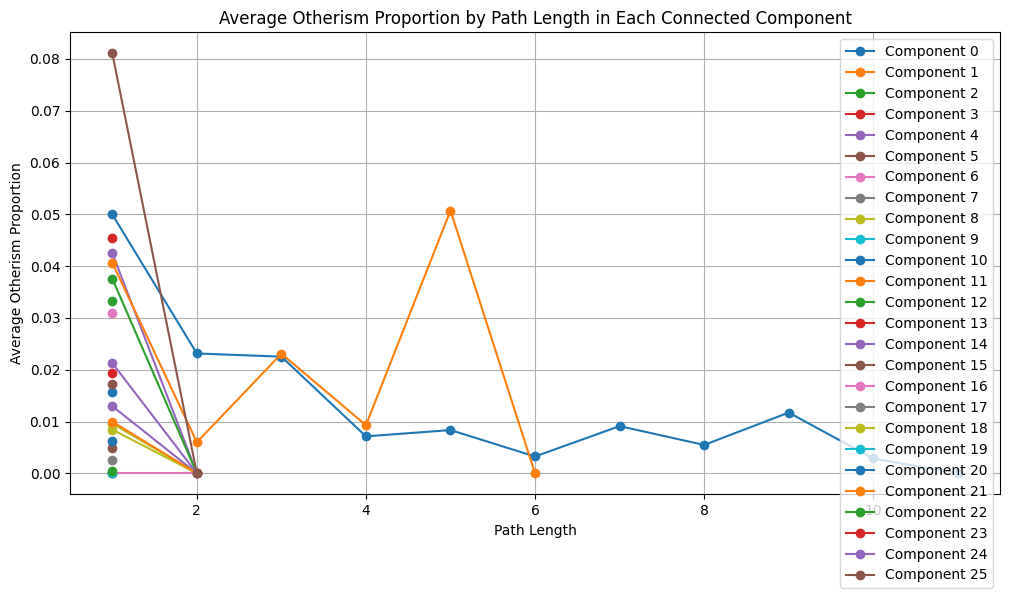

    component_id  path_length  otherism_proportion
0              0            1             0.049977
1              0            2             0.023136
2              0            3             0.022530
3              0            4             0.007136
4              0            5             0.008352
5              0            6             0.003251
6              0            7             0.009115
7              0            8             0.005483
8              0            9             0.011727
9              0           10             0.002868
10             0           11             0.000000
11             1            1             0.000000
12             2            1             0.033333
13             3            1             0.000000
14             4            1             0.042539
15             4            2             0.000000
16             5            1             0.004808
17             6            1             0.030956
18             7            1  

In [17]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

def analyze_otherism_by_path_length_in_components(graph_path, combined_df, classes, thresholds, min_date, max_date):
    """
    Analyze the proportion of otherism in a connected component based on the path length within that component.
    
    Parameters:
    - graph_path: Path to the .graphml file containing the network.
    - combined_df: DataFrame containing channel names and otherism data.
    - classes: List of otherism categories to combine.
    - thresholds: Dictionary containing thresholds for each otherism category.
    - min_date: Minimum date for filtering the combined_df.
    - max_date: Maximum date for filtering the combined_df.
    
    Returns:
    - A DataFrame containing the path length, component ID, and average otherism proportion.
    - A plot showing the relationship between path length and average otherism proportion in each component.
    """
    # Load the graph
    G = nx.read_graphml(graph_path)
    
    # Convert the graph to undirected
    G = G.to_undirected()
    
    # Filter combined_df by date
    combined_df['date'] = pd.to_datetime(combined_df['date'])  # Ensure date column is datetime
    filtered_df = combined_df[(combined_df['date'] >= min_date) & (combined_df['date'] <= max_date)].copy()
    
    # Calculate the combined proportion for the specified classes
    def calculate_combined_proportion(x):
        combined_score = sum((x[category] >= thresholds[category]).astype(int) for category in classes)
        return combined_score.sum() / len(x)
    
    proportions_df = filtered_df.groupby('channel_name').apply(
        lambda x: pd.Series({
            'combined_proportion': calculate_combined_proportion(x)
        })
    ).reset_index()
    
    # Add the combined proportion as a node attribute in the graph
    for index, row in proportions_df.iterrows():
        if row['channel_name'] in G.nodes:
            G.nodes[row['channel_name']]['combined_otherism_proportion'] = row['combined_proportion']
    
    # Analyze path lengths within each connected component
    results = []
    for component_id, component_nodes in enumerate(nx.connected_components(G)):
        subgraph = G.subgraph(component_nodes)
        path_lengths = dict(nx.all_pairs_shortest_path_length(subgraph))
        
        for source, lengths in path_lengths.items():
            for target, length in lengths.items():
                if source != target:
                    source_otherism = G.nodes[source].get('combined_otherism_proportion', 0)
                    results.append({
                        'component_id': component_id,
                        'path_length': length,
                        'otherism_proportion': source_otherism
                    })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    # Calculate average otherism proportion by path length within each component
    avg_otherism_df = results_df.groupby(['component_id', 'path_length'])['otherism_proportion'].mean().reset_index()
    
    # Plot the relationship between path length and average otherism proportion
    plt.figure(figsize=(12, 6))
    for component_id in avg_otherism_df['component_id'].unique():
        component_data = avg_otherism_df[avg_otherism_df['component_id'] == component_id]
        plt.plot(component_data['path_length'], component_data['otherism_proportion'], label=f'Component {component_id}', marker='o')
    
    plt.title('Average Otherism Proportion by Path Length in Each Connected Component')
    plt.xlabel('Path Length')
    plt.ylabel('Average Otherism Proportion')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return avg_otherism_df

# Example usage:
classes = [
           'Threats to Culture or Identity', 
           'Threats to Survival or Physical Security', 
           'Vilification/Villainization',
           'Explicit Dehumanization'
          ]
thresholds = {'Threats to Culture or Identity': 0.99, 'Threats to Survival or Physical Security': 0.9, 
              'Vilification/Villainization': 0.9, 'Explicit Dehumanization': 0.99}
avg_otherism_df = analyze_otherism_by_path_length_in_components('/nas/eclairnas01/users/pgerard/df_ru_with_mentions/russian_graph.graphml', 
                                                                combined_df_ru, classes, thresholds, '2022-02-16', '2022-03-19')

# Display the resulting DataFrame
print(avg_otherism_df)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

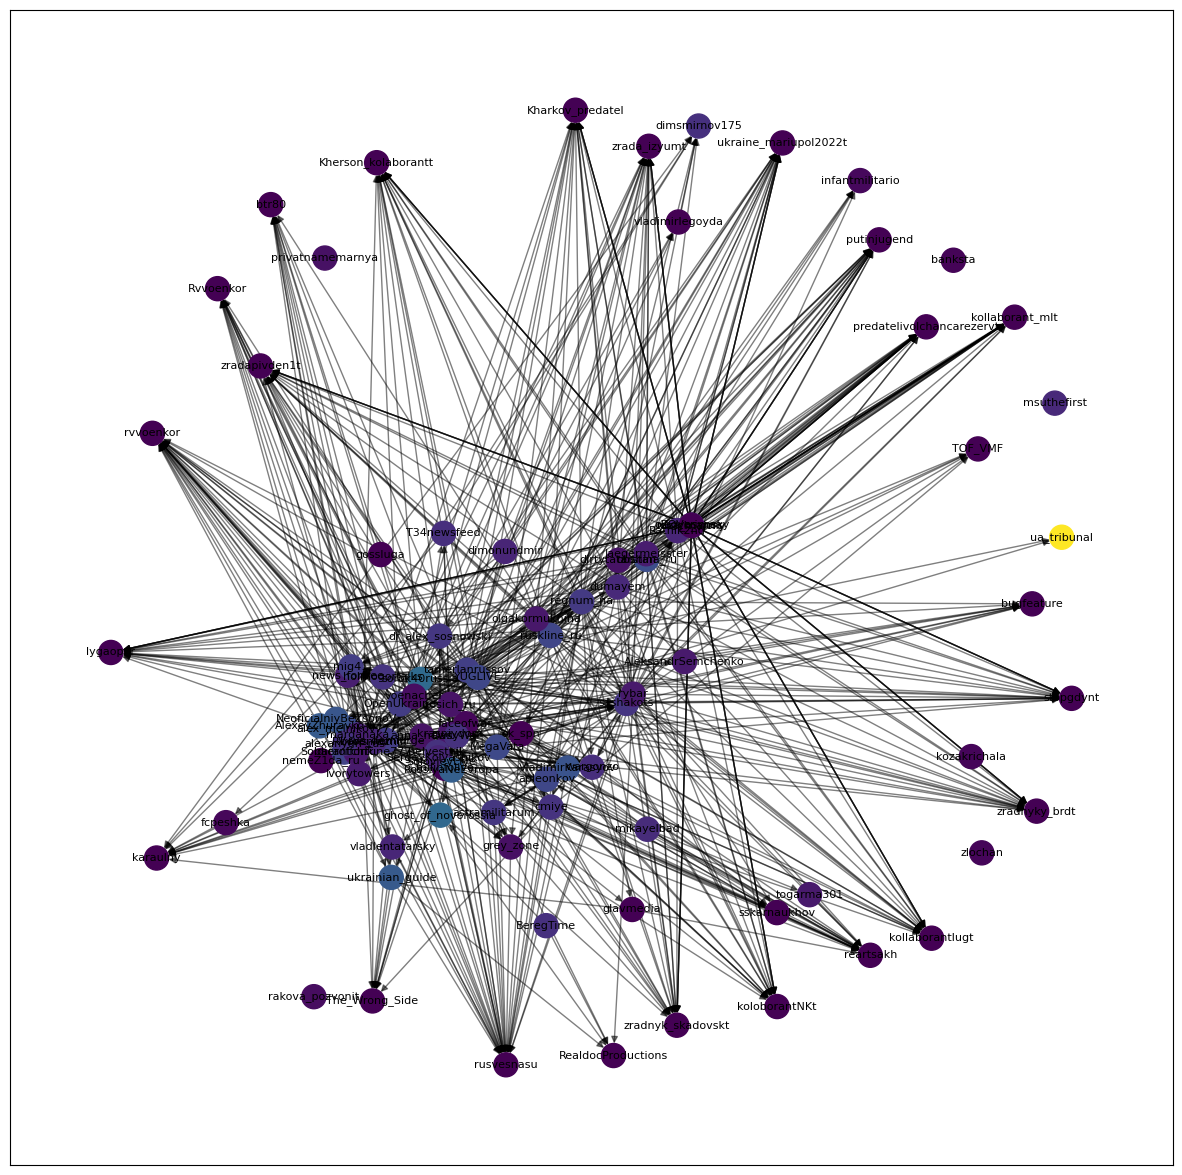

In [8]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
    
def plot_force_based_graph_with_otherism_coloring(graph_path, combined_df, classes, thresholds, min_date, max_date, top_n_nodes=100):
    """
    Function to visualize a graph with nodes color-coded based on the proportion of otherism.
    The graph is visualized using a force-directed layout.
    
    Parameters:
    - graph_path: Path to the .graphml file containing the network.
    - combined_df: DataFrame containing channel names and otherism data.
    - classes: List of otherism categories to combine.
    - thresholds: Dictionary containing thresholds for each otherism category.
    - min_date: Minimum date for filtering the combined_df.
    - max_date: Maximum date for filtering the combined_df.
    - top_n_nodes: Number of top nodes to display based on degree centrality.
    """
    # Load the graph
    G = nx.read_graphml(graph_path)
    
    # Filter combined_df by date
    combined_df['date'] = pd.to_datetime(combined_df['date'])  # Ensure date column is datetime
    filtered_df = combined_df[(combined_df['date'] >= min_date) & (combined_df['date'] <= max_date)].copy()
    
    # Calculate the combined proportion for the specified classes
    def calculate_combined_proportion(x):
        combined_score = sum((x[category] >= thresholds[category]).astype(int) for category in classes)
        return combined_score.sum() / len(x)
    
    proportions_df = filtered_df.groupby('channel_name').apply(
        lambda x: pd.Series({
            'combined_proportion': calculate_combined_proportion(x)
        })
    ).reset_index()
    
    # Map the proportion to each node in the graph
    node_colors = {}
    for index, row in proportions_df.iterrows():
        if row['channel_name'] in G.nodes:
            node_colors[row['channel_name']] = row['combined_proportion']
    
    # Select top N nodes based on degree centrality for clarity
    degree_centrality = nx.degree_centrality(G)
    top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:top_n_nodes]
    subgraph = G.subgraph(top_nodes)
    
    # Normalize the proportions for color mapping
    norm = mcolors.Normalize(vmin=min(node_colors.values()), vmax=max(node_colors.values()))
    cmap = plt.cm.viridis  # You can choose any color map you prefer
    
    # Assign colors to nodes based on the normalized proportions
    node_color_values = [cmap(norm(node_colors.get(node, 0))) for node in subgraph.nodes()]
    
    # Draw the graph with color-coded nodes using a force-directed layout
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(subgraph, seed=42)  # Force-directed layout

    nx.draw_networkx_nodes(subgraph, pos, node_color=node_color_values, node_size=300)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
    nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color="black")
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Otherism Proportion')
    
    plt.title(f'Force-Directed Graph with Top {top_n_nodes} Nodes Color-Coded by Otherism Proportion')
    plt.show()

# Example usage:
classes = [
           'Threats to Culture or Identity', 
           'Threats to Survival or Physical Security', 
           'Vilification/Villainization',
           'Explicit Dehumanization'
          ]
thresholds = {'Threats to Culture or Identity': 0.99, 'Threats to Survival or Physical Security': 0.9, 
              'Vilification/Villainization': 0.9, 'Explicit Dehumanization': 0.99}
plot_force_based_graph_with_otherism_coloring('/nas/eclairnas01/users/pgerard/df_ru_with_mentions/russian_graph.graphml', 
                                              combined_df_ru, classes, thresholds, '2022-02-16', '2022-03-19', top_n_nodes=100)


In [12]:
import networkx as nx
import pandas as pd

def export_graph_for_gephi(graph_path, combined_df, classes, thresholds, min_date, max_date, output_path):
    """
    Function to combine specified otherism categories, calculate their combined proportion, 
    add this as a node attribute, and export the graph to GraphML format for Gephi.
    
    Parameters:
    - graph_path: Path to the .graphml file containing the network.
    - combined_df: DataFrame containing channel names and otherism data.
    - classes: List of otherism categories to combine.
    - thresholds: Dictionary containing thresholds for each otherism category.
    - min_date: Minimum date for filtering the combined_df.
    - max_date: Maximum date for filtering the combined_df.
    - output_path: Path to save the modified GraphML file.
    """
    # Load the graph
    G = nx.read_graphml(graph_path)
    
    # Filter combined_df by date
    combined_df['date'] = pd.to_datetime(combined_df['date'])  # Ensure date column is datetime
    filtered_df = combined_df[(combined_df['date'] >= min_date) & (combined_df['date'] <= max_date)].copy()
    
    # Calculate the combined proportion for the specified classes
    def calculate_combined_proportion(x):
        combined_score = sum((x[category] >= thresholds[category]).astype(int) for category in classes)
        return combined_score.sum() / len(x)
    
    proportions_df = filtered_df.groupby('channel_name').apply(
        lambda x: pd.Series({
            'combined_proportion': calculate_combined_proportion(x)
        })
    ).reset_index()
    
    # Add the combined proportion as a node attribute in the graph
    for index, row in proportions_df.iterrows():
        if row['channel_name'] in G.nodes:
            G.nodes[row['channel_name']]['combined_otherism_proportion'] = row['combined_proportion']
    
    # Export the graph to GraphML format for use in Gephi
    nx.write_graphml(G, output_path)
    print(f"Graph exported to {output_path} with combined otherism proportions as node attributes.")

# Example usage:
classes = [
           'Threats to Culture or Identity', 
           'Threats to Survival or Physical Security', 
           'Vilification/Villainization',
           'Explicit Dehumanization'
          ]
thresholds = {'Threats to Culture or Identity': 0.99, 'Threats to Survival or Physical Security': 0.9, 
              'Vilification/Villainization': 0.9, 'Explicit Dehumanization': 0.99}
export_graph_for_gephi('/nas/eclairnas01/users/pgerard/df_ru_with_mentions/russian_graph.graphml', 
                       combined_df_ru, classes, thresholds, '2022-02-16', '2022-03-19',
                       '/nas/eclairnas01/users/pgerard/df_ru_with_mentions/russian_graph_with_otherism_gephi.graphml')


Graph exported to /nas/eclairnas01/users/pgerard/df_ru_with_mentions/russian_graph_with_otherism_gephi.graphml with combined otherism proportions as node attributes.


Top n% versus the others -- look at the trends in otherism

In [32]:
len(network_edges)

2800

In [33]:
len(network_graph.nodes())

1422

In [34]:
output_graphml_path = '/nas/eclairnas01/users/pgerard/df_ru_with_mentions/russian_graph.graphml'  # Path
nx.write_graphml(network_graph, output_graphml_path)